In [1]:
import json, base64, glob
from IPython.display import display, Image, HTML, Markdown

In [2]:
# ============================================================
# EDA Plot Descriptions
# ============================================================
descriptions = {
    "01_state_distribution": {
        "title": "1. Order State Distribution",
        "desc": """Shows the count of orders in each state (e.g. CLOSED, CANCELLED, etc.).
        This is essentially your **target variable overview** — helps you understand class balance.
        If one state dominates, you may need stratified sampling or class weighting in modeling."""
    },
    "02_top20_services": {
        "title": "2. Top 20 Services",
        "desc": """Horizontal bar chart of the 20 most frequently ordered services (e.g. cooler, grooming, locksmith).
        Reveals which services drive the most volume. Long-tail services with few orders
        may behave differently and could need special handling or grouping."""
    },
    "03_top15_categories": {
        "title": "3. Top 15 Categories",
        "desc": """Similar to services but at the **category level** (e.g. cleaning, renovation, repair).
        Shows the high-level business segments. Useful for feature engineering —
        you might group rare categories into 'other'."""
    },
    "04_payment_method": {
        "title": "4. Payment Method",
        "desc": """Pie chart showing CASH vs other payment methods.
        If one method overwhelmingly dominates, this feature may have low predictive power.
        Also reveals business insight about customer payment preferences."""
    },
    "05_gender": {
        "title": "5. Customer Gender",
        "desc": """Pie chart of MALE / FEMALE / missing gender.
        Shows demographic split of customers. Note the ~16K missing values.
        Gender imbalance may reflect the nature of home services."""
    },
    "06_device": {
        "title": "6. Device Distribution",
        "desc": """Bar chart of devices used to place orders (android, ios, web).
        Indicates the platform mix. Could correlate with customer demographics
        or behavior patterns (e.g. web users might be more deliberate)."""
    },
    "07_numeric_distributions": {
        "title": "7. Numeric Feature Distributions",
        "desc": """Grid of histograms for 10 key numeric features (clipped to 1st-99th percentile to remove outliers):
        - **Selected_Price**: order price — likely right-skewed
        - **Duration**: service duration in hours
        - **Customer_CharehPoints**: loyalty points
        - **Customer_PreviousOrdersCount**: repeat usage
        - **arranged_expert_rate**: expert rating
        - **arranged_expert_successful_jobs**: expert experience
        - **Time_to_First_Contract**: minutes until first expert responds
        - **Time_to_Service**: minutes from order creation to service start
        - **Customer_Account_Age**: how old the customer account is
        - **Customer_Order_Rate**: order frequency
        
        Look for: skewness (may need log transform), bimodal patterns, zero-inflation."""
    },
    "08_correlation_heatmap": {
        "title": "8. Full Correlation Heatmap",
        "desc": """Lower-triangle heatmap of Pearson correlations between ALL numeric features.
        Color scale: red = positive, blue = negative correlation.
        Use this to spot:
        - **Multicollinearity** (highly correlated feature pairs — redundant for models)
        - **Target-correlated features** (if State is encoded)
        - **Feature clusters** that move together"""
    },
    "09_top_correlations": {
        "title": "9. Top 30 Correlated Feature Pairs",
        "desc": """Zoomed-in view: the 30 strongest absolute correlations between feature pairs.
        Green = positive, Red = negative.
        Highly correlated pairs (|r| > 0.8) are candidates for dropping one of the two.
        E.g. expert contracts count vs done contracts count are likely near-duplicates."""
    },
    "10_orders_over_time": {
        "title": "10. Orders Over Time (Year & Season)",
        "desc": """Two plots side by side:
        - **Left**: order volume by year (2021-2023) — shows business growth/decline
        - **Right**: order volume by season — reveals seasonality
        
        Seasonality matters for time-based splits and for understanding demand cycles."""
    },
    "11_hourly_pattern": {
        "title": "11. Hourly Order Pattern",
        "desc": """Line chart of order creation count by hour of day (0-23).
        Shows when customers place orders — expect peaks in morning/evening.
        Useful for understanding customer behavior and could be a predictive feature."""
    },
    "12_day_of_week": {
        "title": "12. Day of Week Pattern",
        "desc": """Bar chart of orders by weekday (Mon-Sun).
        Shows weekly demand cycles. If weekends differ significantly from weekdays,
        this feature carries signal. Note: in Iran, the weekend is Thu-Fri."""
    },
    "13_allocation_counselling": {
        "title": "13. Allocation Type & Counselling Needed",
        "desc": """Two bar charts:
        - **Allocation Type**: AUTOMATIC vs MANUAL allocation of experts — 
          shows how orders are matched to service providers
        - **Counselling Needed**: whether the order required pre-service consultation (True/False)
        
        These are process-related features that may strongly predict outcomes."""
    },
    "14_price_by_state": {
        "title": "14. Price Distribution by Order State",
        "desc": """Boxplots of Selected_Price grouped by order State (clipped to 5th-95th percentile).
        Shows whether price differs across outcomes (CLOSED, CANCELLED, etc.).
        If cancelled orders have systematically different prices, price is predictive.
        Look for differences in medians and spread across states."""
    },
    "15_missing_values": {
        "title": "15. Missing Values Summary",
        "desc": """Horizontal bar chart showing columns with missing data and their percentage.
        Key for data cleaning decisions:
        - High missing (>20%): consider dropping or creating a 'missing' indicator
        - Low missing (<5%): impute with median/mode
        - Pattern matters: if missingness correlates with the target, it's informative (MNAR)"""
    },
    "16_target_distribution": {
        "title": "16. Target Variable Distribution",
        "desc": """Bar charts showing True/False counts for **Customer_return3Months** and **Customer_return6Months**.
        This is your **class balance check**. If one class dominates (e.g. 80% True),
        you'll likely need techniques like SMOTE, class weights, or stratified splits during modeling."""
    },
    "17_return_by_state": {
        "title": "17. Return Rate by Order State",
        "desc": """Return rate (proportion returning) grouped by order State (CLOSED, CANCELLED, etc.).
        Shows if order outcome strongly predicts return behavior — e.g. customers with cancelled orders
        may be much less likely to return. **High signal feature.**"""
    },
    "18_return_by_service": {
        "title": "18. Return Rate by Service (Top 15)",
        "desc": """Return rate for the 15 most popular services. Some services naturally have higher
        repeat rates (e.g. cleaning is recurring, locksmith is one-time). This reveals which
        services are sticky and can guide business decisions about customer retention."""
    },
    "19_return_by_category": {
        "title": "19. Return Rate by Category (Top 10)",
        "desc": """Same idea as service-level but aggregated to category. Categories like 'cleaning'
        likely show higher return rates than 'renovation'. Useful for grouping services in modeling."""
    },
    "20_return_by_payment": {
        "title": "20. Return Rate by Payment Method",
        "desc": """Return rate split by CASH vs other payment methods.
        If online payment users return more, it may indicate higher engagement/trust.
        Small differences here can still be statistically significant with 400K+ rows."""
    },
    "21_return_by_gender": {
        "title": "21. Return Rate by Gender",
        "desc": """Return rate by MALE / FEMALE. Shows if gender is a useful predictor.
        Even small differences matter at scale. Also consider the ~16K missing gender values."""
    },
    "22_return_by_device": {
        "title": "22. Return Rate by Device",
        "desc": """Return rate by device (android, ios, web). Platform differences may reflect
        different user segments — e.g. iOS users might have higher purchasing power and different return behavior."""
    },
    "23_return_by_allocation": {
        "title": "23. Return Rate by Allocation Type",
        "desc": """Return rate for AUTOMATIC vs MANUAL expert allocation.
        If manual allocation leads to higher returns, it suggests better expert-customer matching matters.
        Important operational insight for the platform."""
    },
    "24_return_by_hour": {
        "title": "24. Return Rate by Hour of Day",
        "desc": """Line chart showing return rate across 24 hours. Reveals if time-of-order
        correlates with return behavior. Late-night or early-morning orders might indicate
        different customer segments with different loyalty patterns."""
    },
    "25_return_by_dayofweek": {
        "title": "25. Return Rate by Day of Week",
        "desc": """Return rate by weekday (Mon-Sun). In Iran, weekend is Thu-Fri,
        so weekend vs weekday ordering behavior may differ. Look for any day that
        stands out significantly from the rest."""
    },
    "26_return_by_year_season": {
        "title": "26. Return Rate by Year & Season",
        "desc": """Four plots: return rate by year and season for both 3M and 6M targets.
        - **Year trend**: is return rate improving or declining over time?
        - **Season**: any seasonal pattern in customer loyalty?
        Important for understanding data drift and temporal effects in train/test splits."""
    },
    "27_return_by_prev_orders": {
        "title": "27. Return Rate by Previous Orders (Binned)",
        "desc": """Return rate bucketed by how many previous orders the customer had (0, 1-2, 3-5, ..., 21+).
        Expect a strong positive relationship — customers who ordered more before are more likely to return.
        This is likely one of the **strongest predictors** but beware of data leakage if this is computed at prediction time."""
    },
    "28_features_by_return3m": {
        "title": "28. Feature Distributions: Return vs No-Return (3 Months)",
        "desc": """Overlapping normalized histograms for 10 key numeric features, colored by return3M outcome.
        Green = returning customers, Red = non-returning.
        Look for features where the two distributions **separate clearly** — those have the most predictive power.
        Features where distributions overlap completely are less useful."""
    },
    "29_return_by_counselling_description": {
        "title": "29. Return by Counselling & Has Description",
        "desc": """Stacked bar charts showing return proportion split by:
        - **Counselling_Needed**: does pre-service consultation affect return?
        - **Has_Description**: does having an order description correlate with return?
        These boolean features may capture customer engagement level."""
    },
    "30_3m_vs_6m_crosstab": {
        "title": "30. 3-Month vs 6-Month Return Cross-Tabulation",
        "desc": """Heatmap showing the overlap between the two targets.
        Key questions: How many customers who return within 3M also return within 6M?
        Are there customers who return in 6M but NOT 3M? This helps you decide
        whether to model them separately or treat 6M as a superset of 3M."""
    },
}

Found 30 plot files



Shows the count of orders in each state (e.g. CLOSED, CANCELLED, etc.).
        This is essentially your **target variable overview** — helps you understand class balance.
        If one state dominates, you may need stratified sampling or class weighting in modeling.

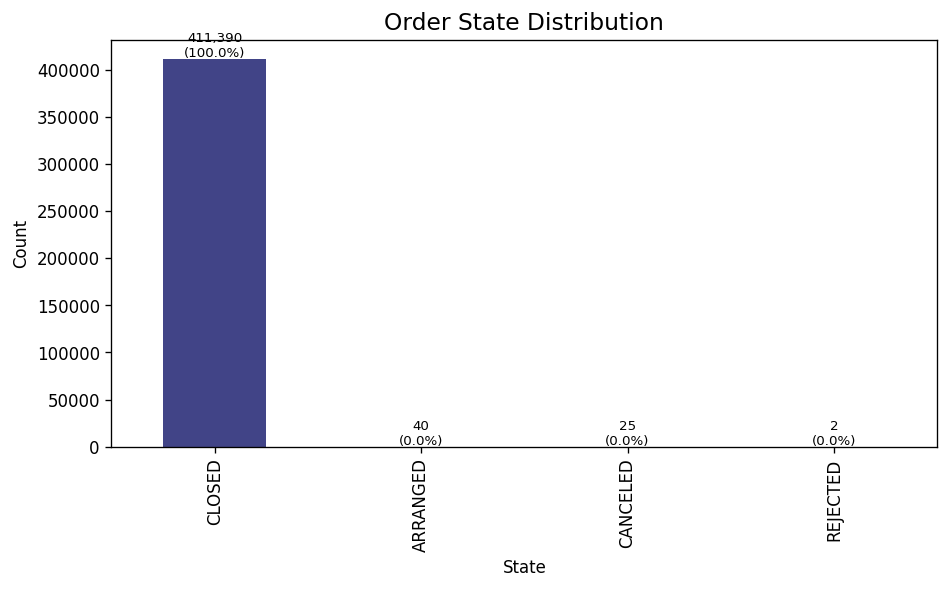

Horizontal bar chart of the 20 most frequently ordered services (e.g. cooler, grooming, locksmith).
        Reveals which services drive the most volume. Long-tail services with few orders
        may behave differently and could need special handling or grouping.

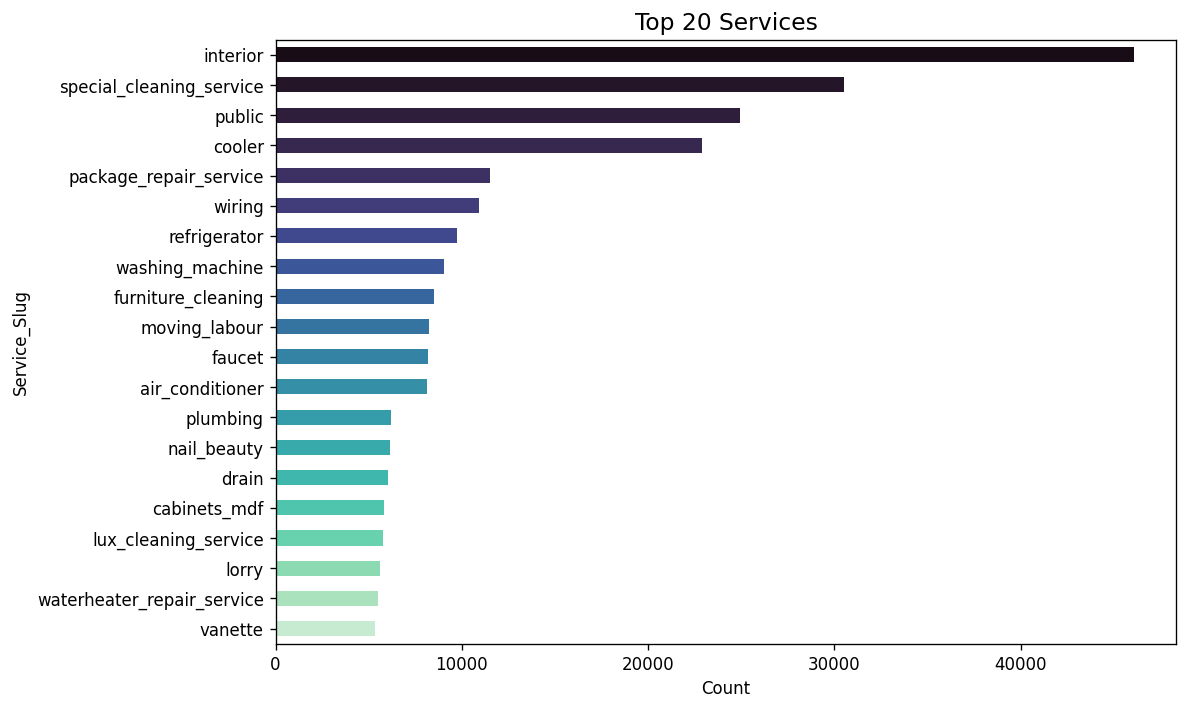

Similar to services but at the **category level** (e.g. cleaning, renovation, repair).
        Shows the high-level business segments. Useful for feature engineering —
        you might group rare categories into 'other'.

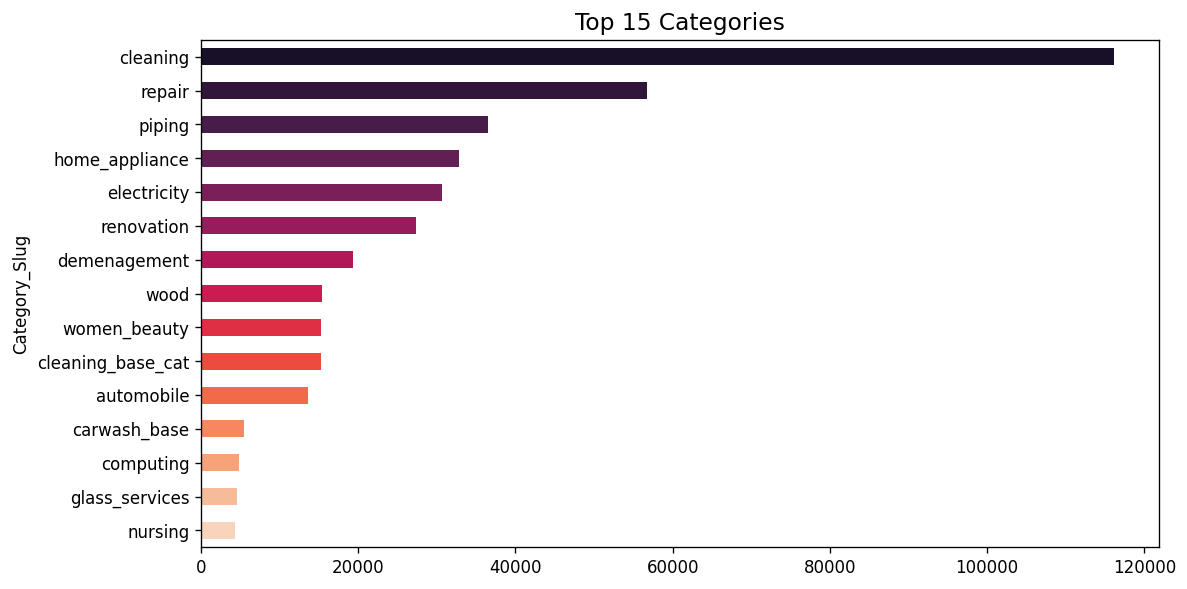

Pie chart showing CASH vs other payment methods.
        If one method overwhelmingly dominates, this feature may have low predictive power.
        Also reveals business insight about customer payment preferences.

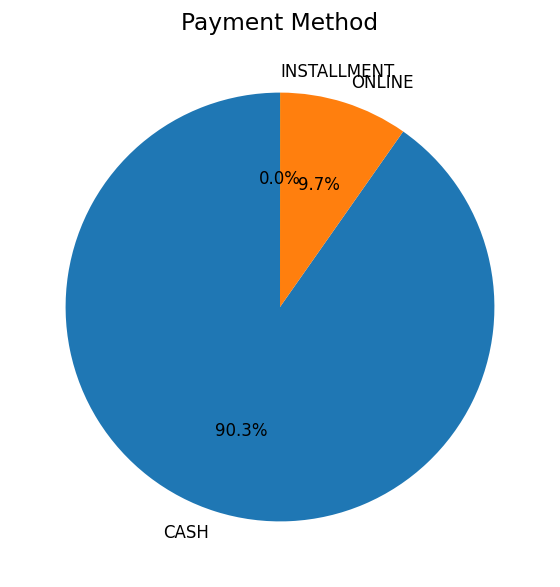

Pie chart of MALE / FEMALE / missing gender.
        Shows demographic split of customers. Note the ~16K missing values.
        Gender imbalance may reflect the nature of home services.

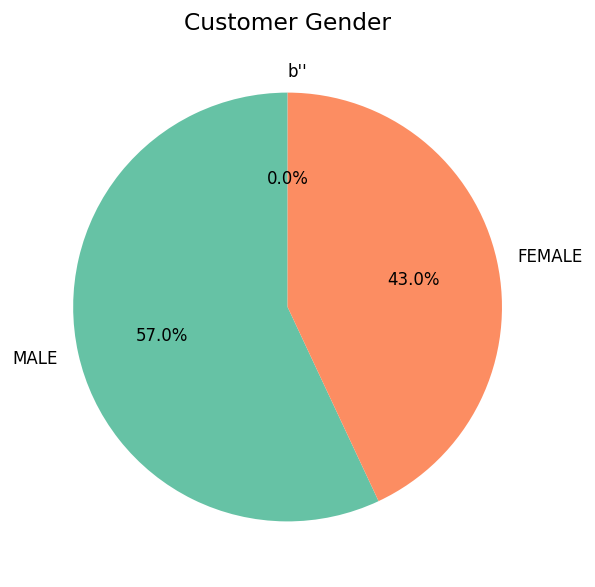

Bar chart of devices used to place orders (android, ios, web).
        Indicates the platform mix. Could correlate with customer demographics
        or behavior patterns (e.g. web users might be more deliberate).

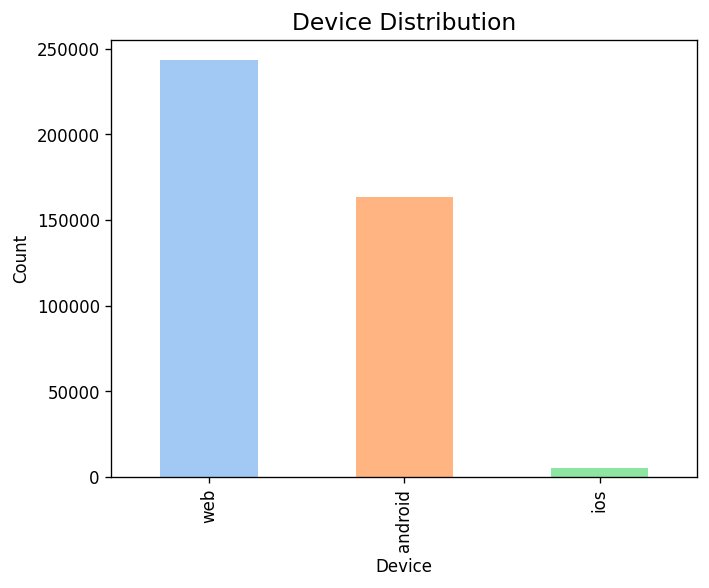

Grid of histograms for 10 key numeric features (clipped to 1st-99th percentile to remove outliers):
        - **Selected_Price**: order price — likely right-skewed
        - **Duration**: service duration in hours
        - **Customer_CharehPoints**: loyalty points
        - **Customer_PreviousOrdersCount**: repeat usage
        - **arranged_expert_rate**: expert rating
        - **arranged_expert_successful_jobs**: expert experience
        - **Time_to_First_Contract**: minutes until first expert responds
        - **Time_to_Service**: minutes from order creation to service start
        - **Customer_Account_Age**: how old the customer account is
        - **Customer_Order_Rate**: order frequency

        Look for: skewness (may need log transform), bimodal patterns, zero-inflation.

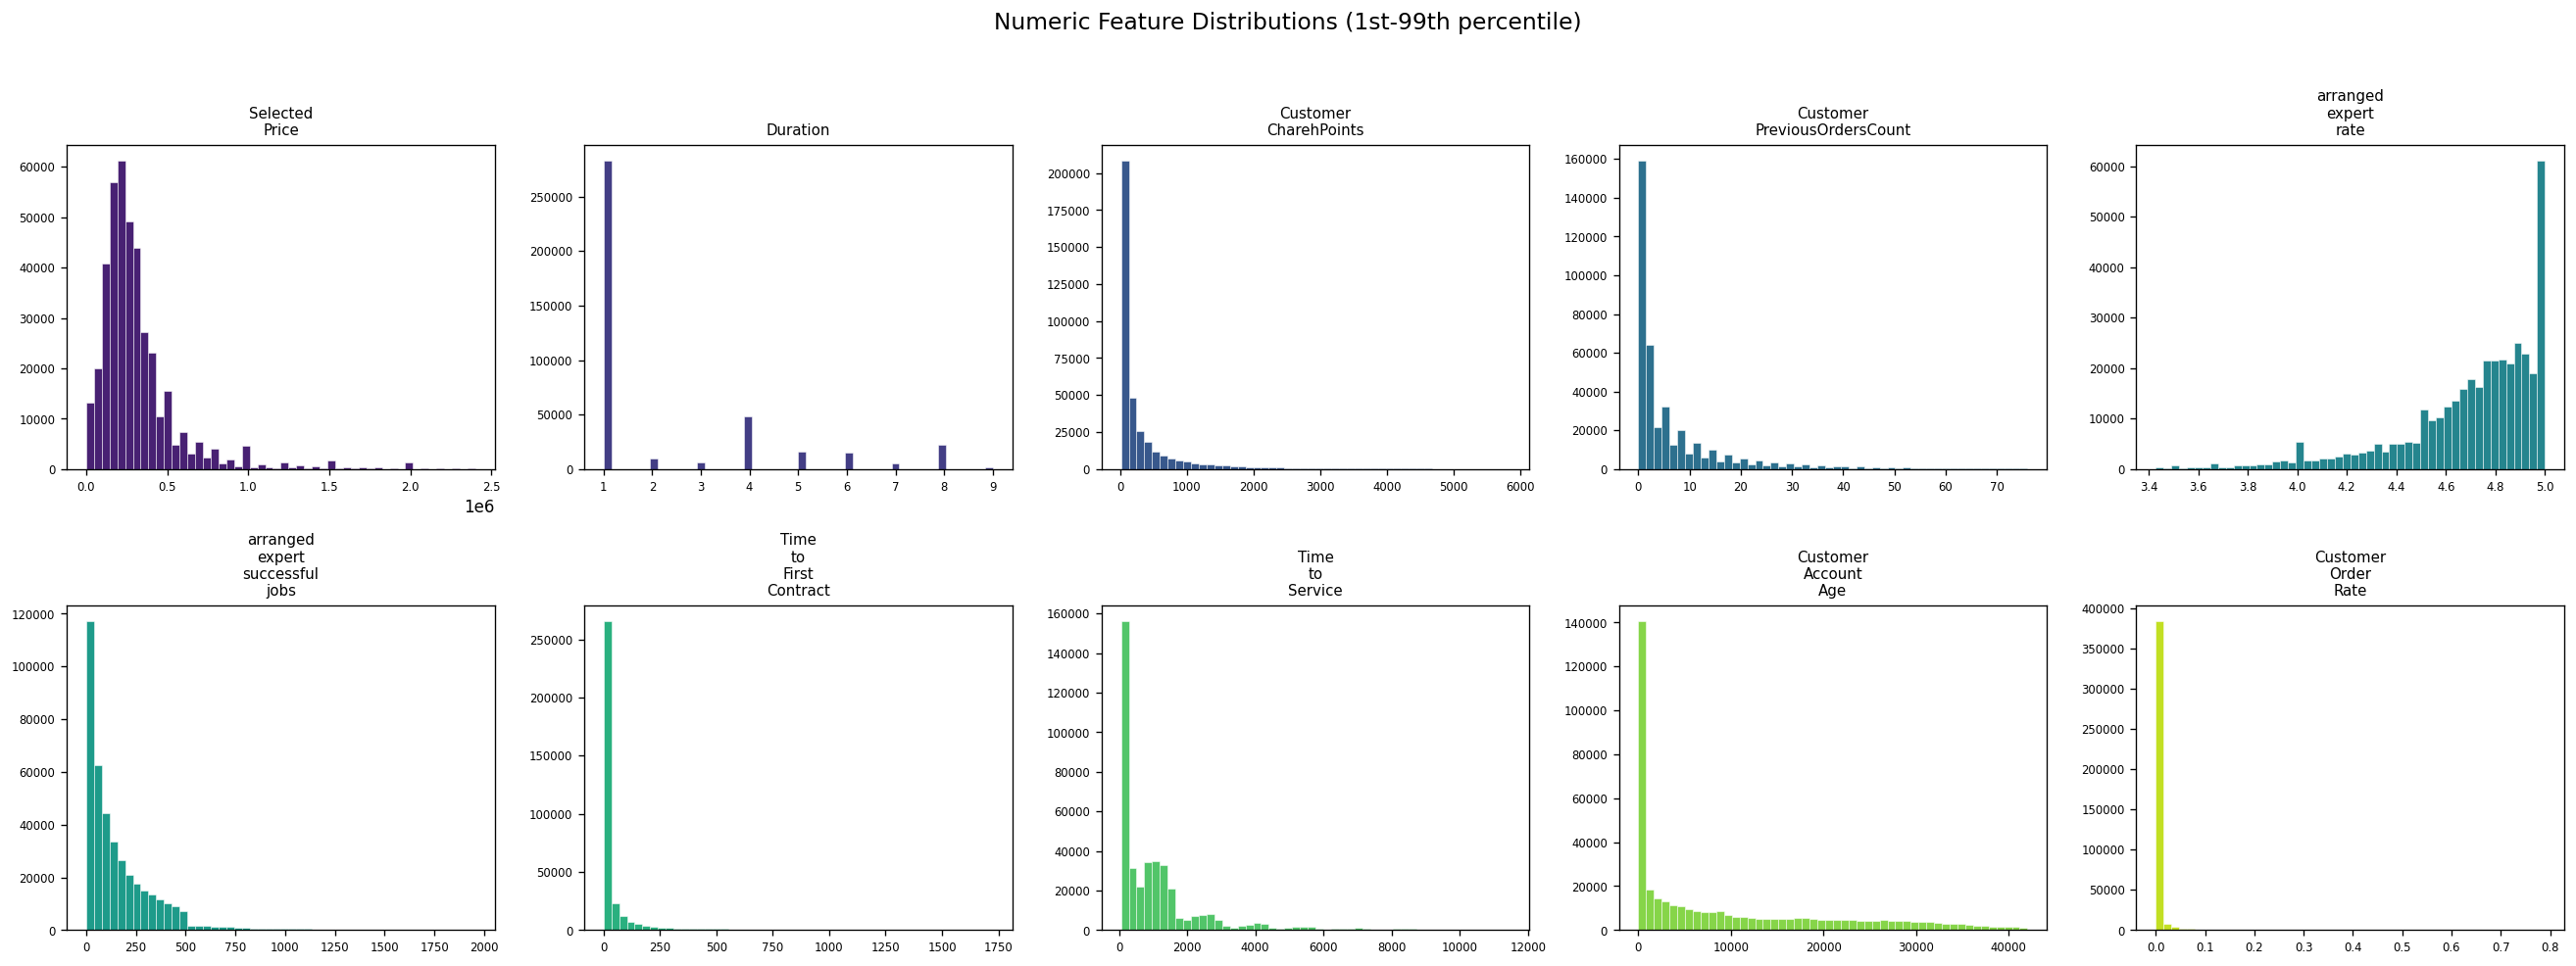

Lower-triangle heatmap of Pearson correlations between ALL numeric features.
        Color scale: red = positive, blue = negative correlation.
        Use this to spot:
        - **Multicollinearity** (highly correlated feature pairs — redundant for models)
        - **Target-correlated features** (if State is encoded)
        - **Feature clusters** that move together

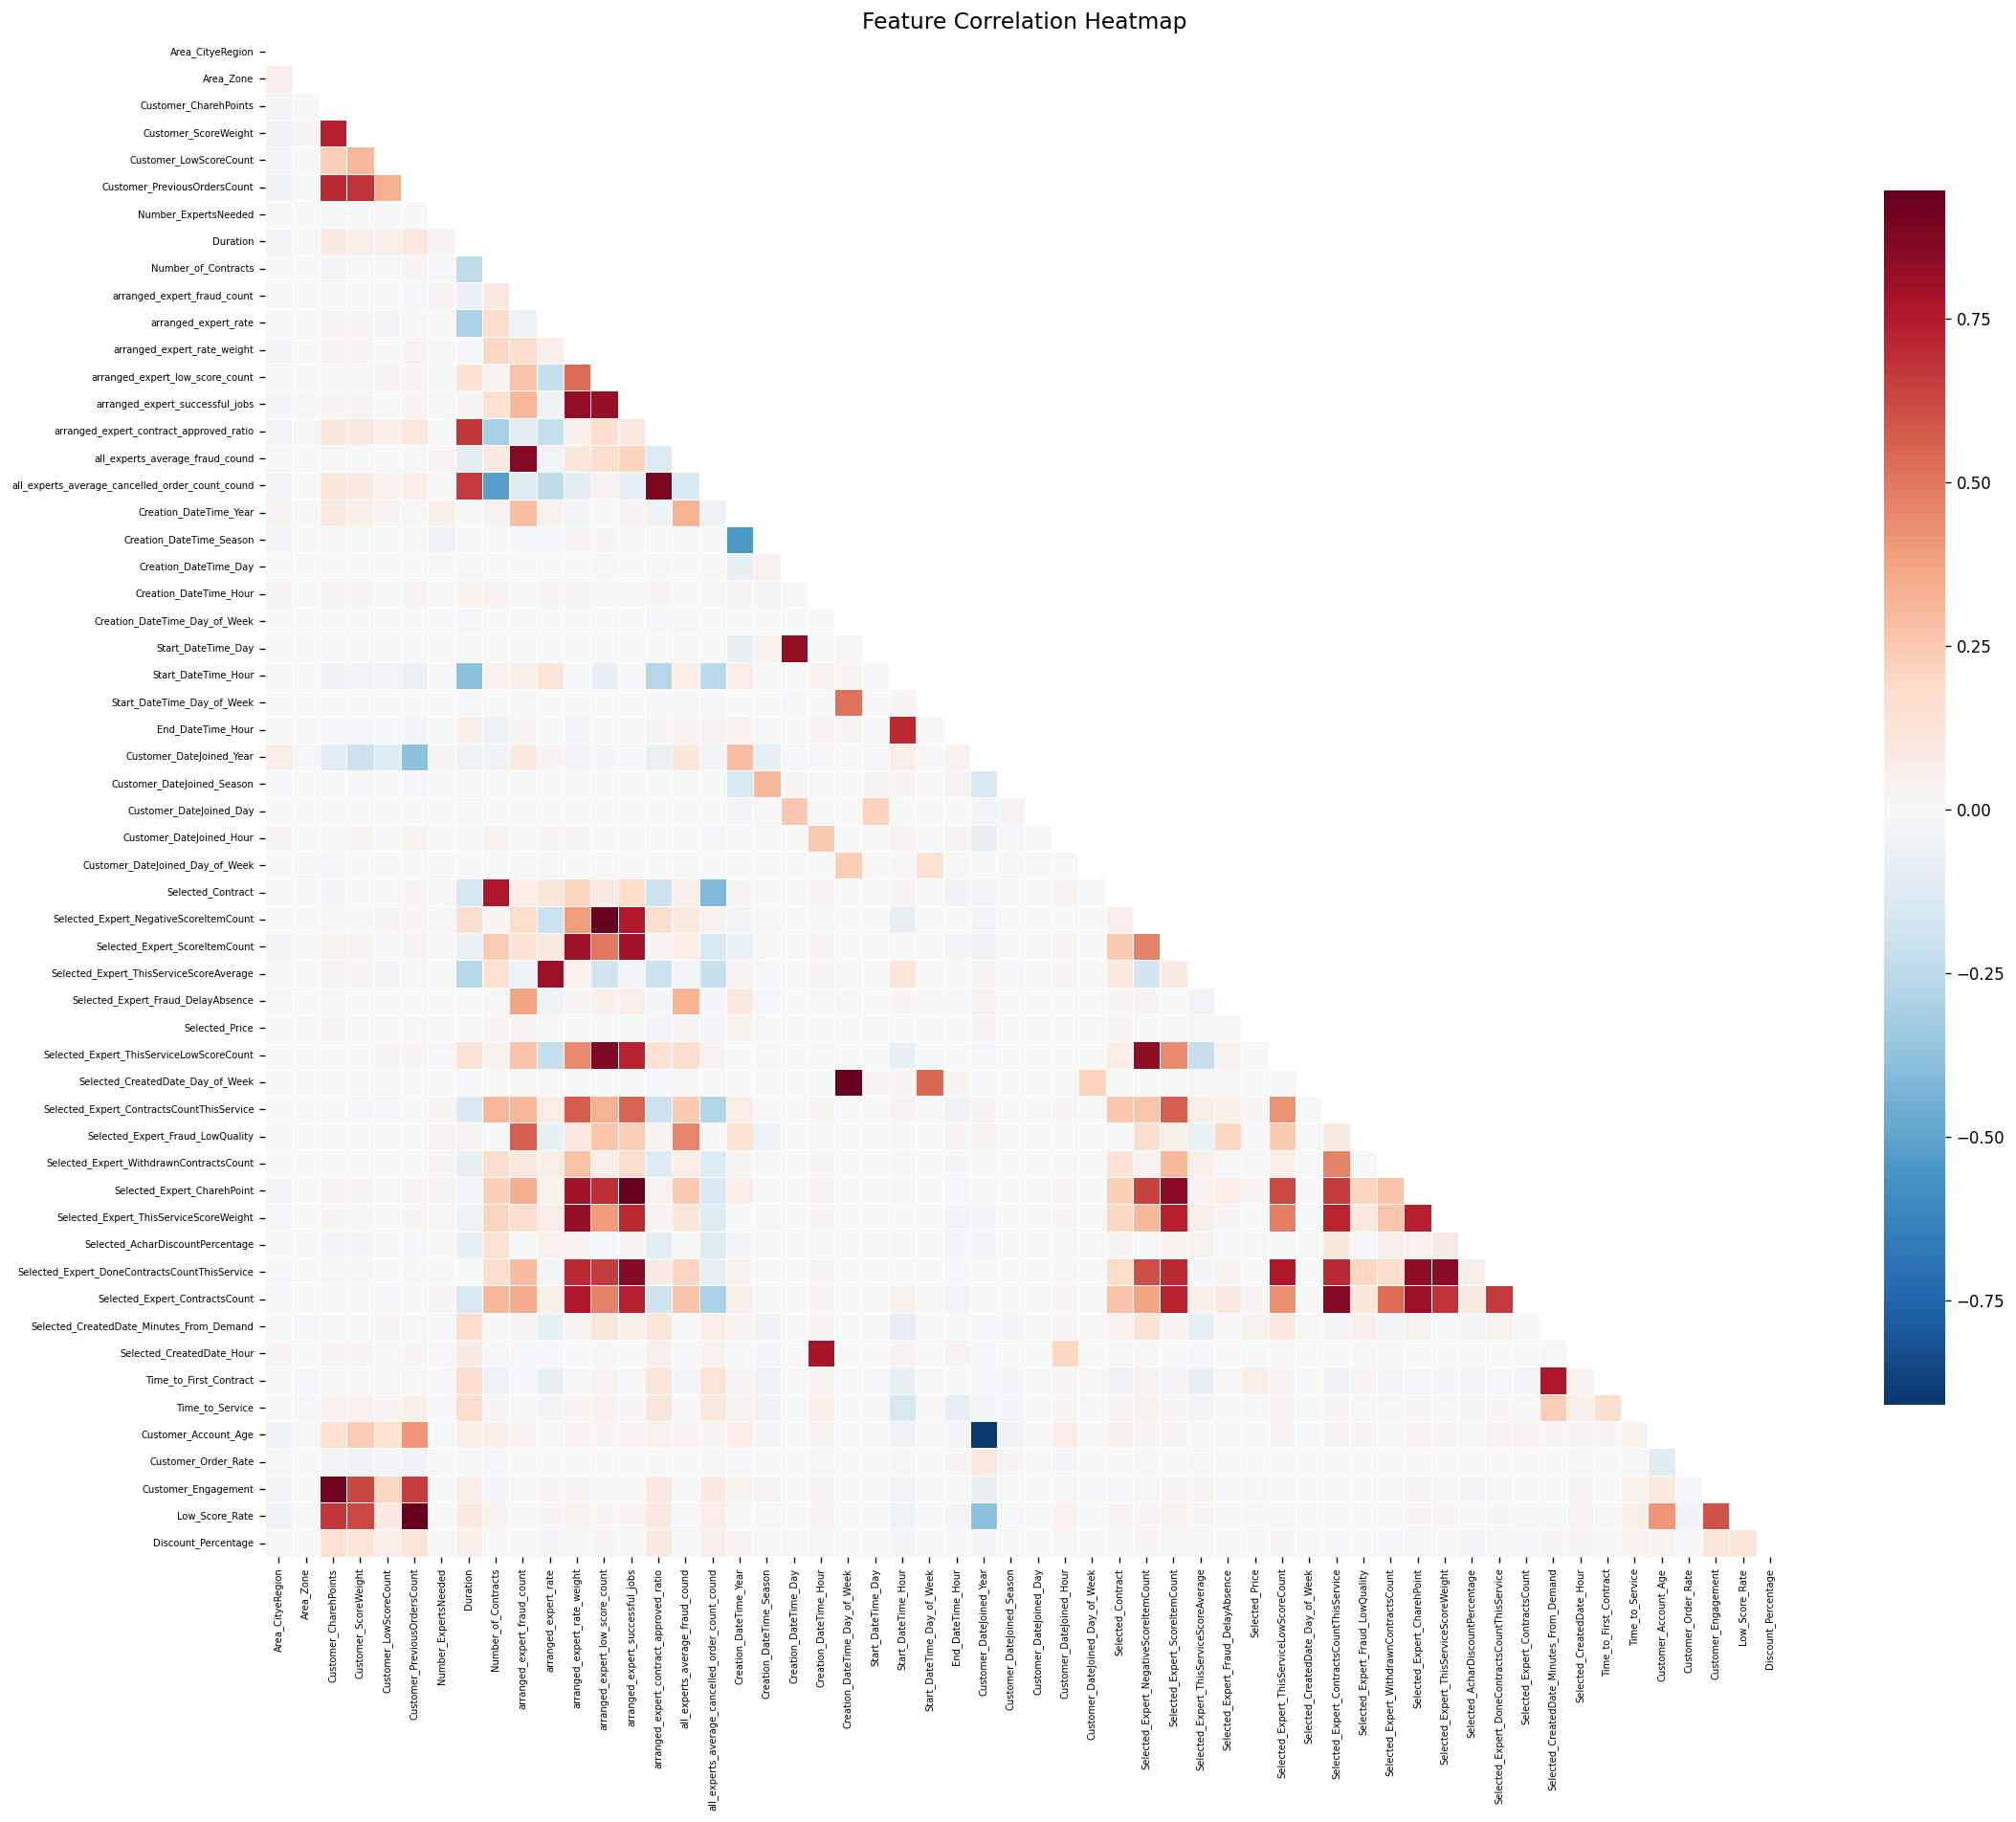

Zoomed-in view: the 30 strongest absolute correlations between feature pairs.
        Green = positive, Red = negative.
        Highly correlated pairs (|r| > 0.8) are candidates for dropping one of the two.
        E.g. expert contracts count vs done contracts count are likely near-duplicates.

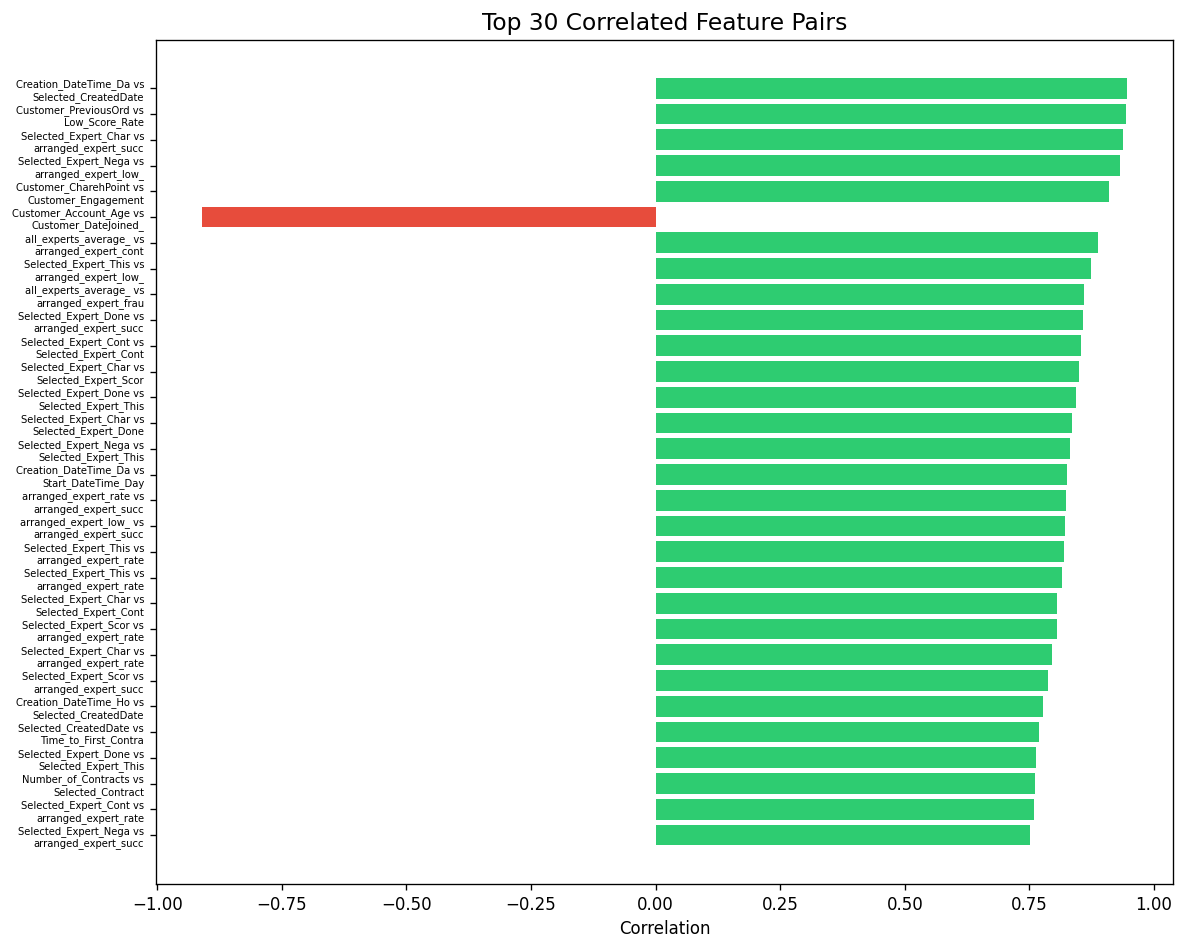

Two plots side by side:
        - **Left**: order volume by year (2021-2023) — shows business growth/decline
        - **Right**: order volume by season — reveals seasonality

        Seasonality matters for time-based splits and for understanding demand cycles.

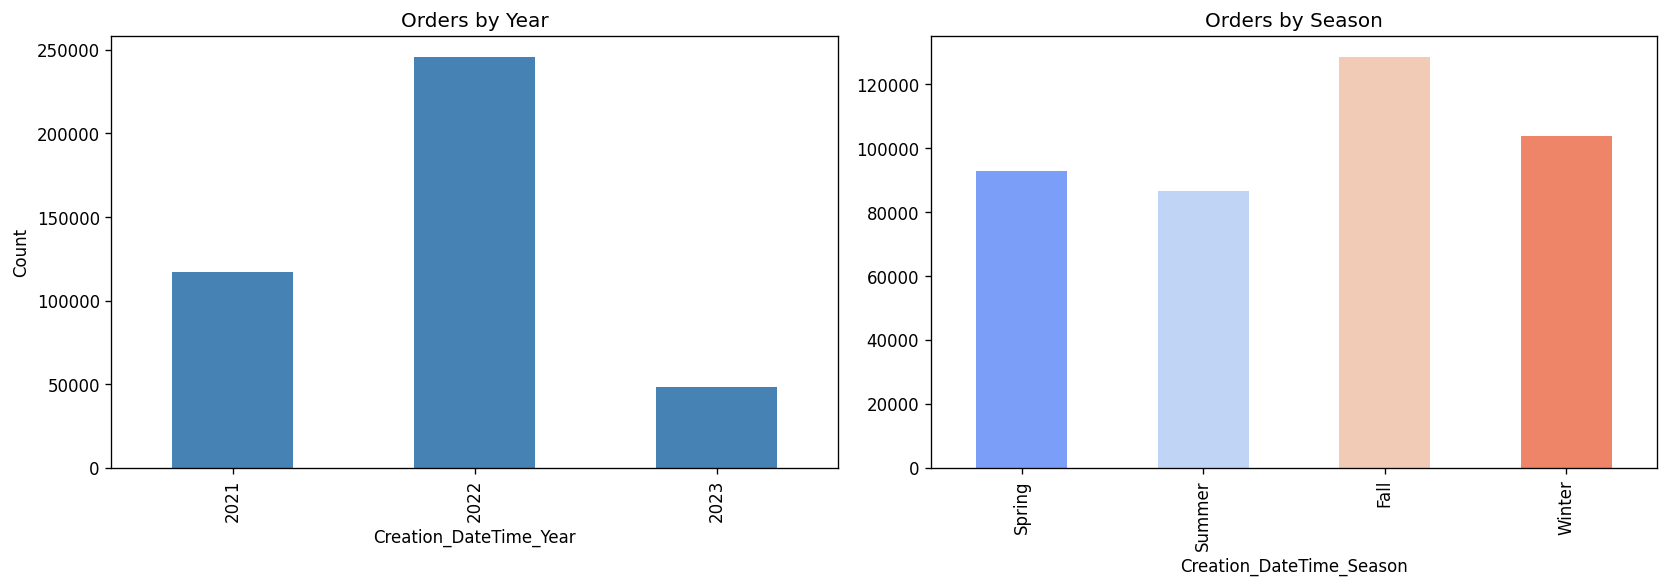

Line chart of order creation count by hour of day (0-23).
        Shows when customers place orders — expect peaks in morning/evening.
        Useful for understanding customer behavior and could be a predictive feature.

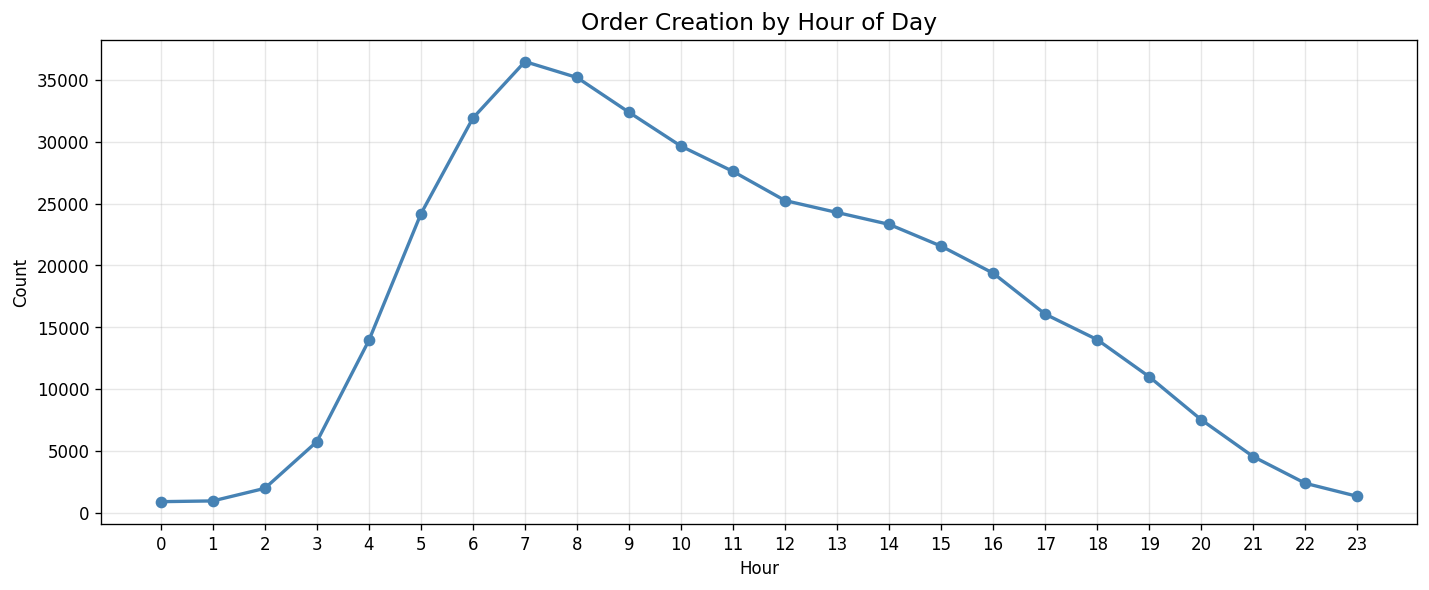

Bar chart of orders by weekday (Mon-Sun).
        Shows weekly demand cycles. If weekends differ significantly from weekdays,
        this feature carries signal. Note: in Iran, the weekend is Thu-Fri.

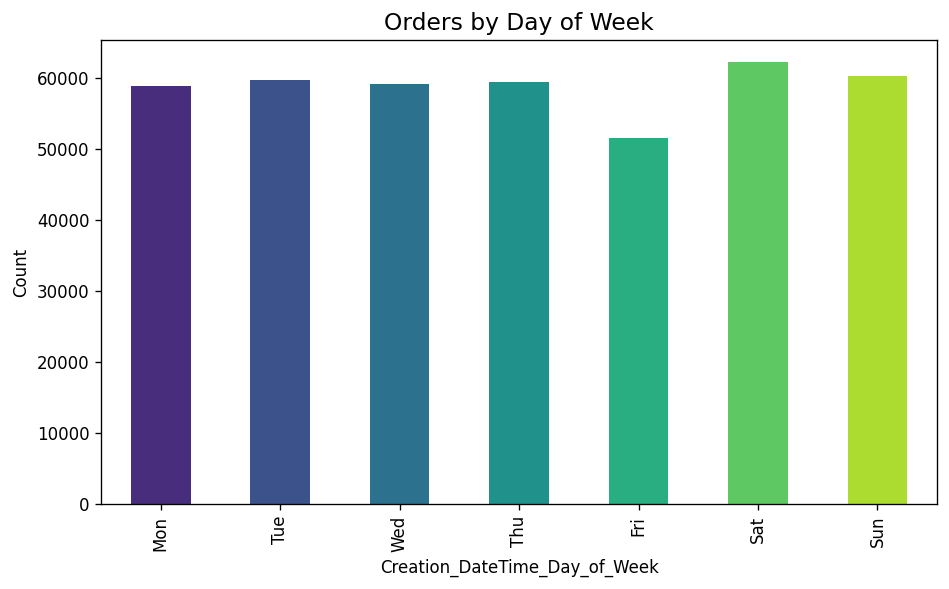

Two bar charts:
        - **Allocation Type**: AUTOMATIC vs MANUAL allocation of experts — 
          shows how orders are matched to service providers
        - **Counselling Needed**: whether the order required pre-service consultation (True/False)

        These are process-related features that may strongly predict outcomes.

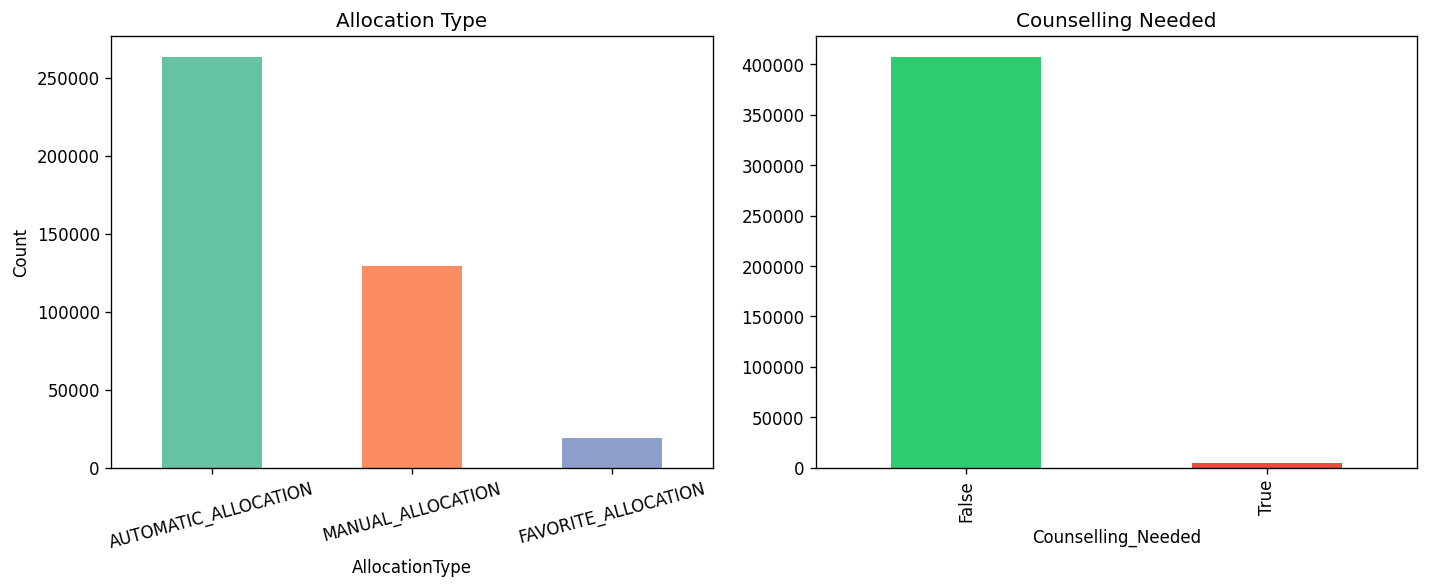

Boxplots of Selected_Price grouped by order State (clipped to 5th-95th percentile).
        Shows whether price differs across outcomes (CLOSED, CANCELLED, etc.).
        If cancelled orders have systematically different prices, price is predictive.
        Look for differences in medians and spread across states.

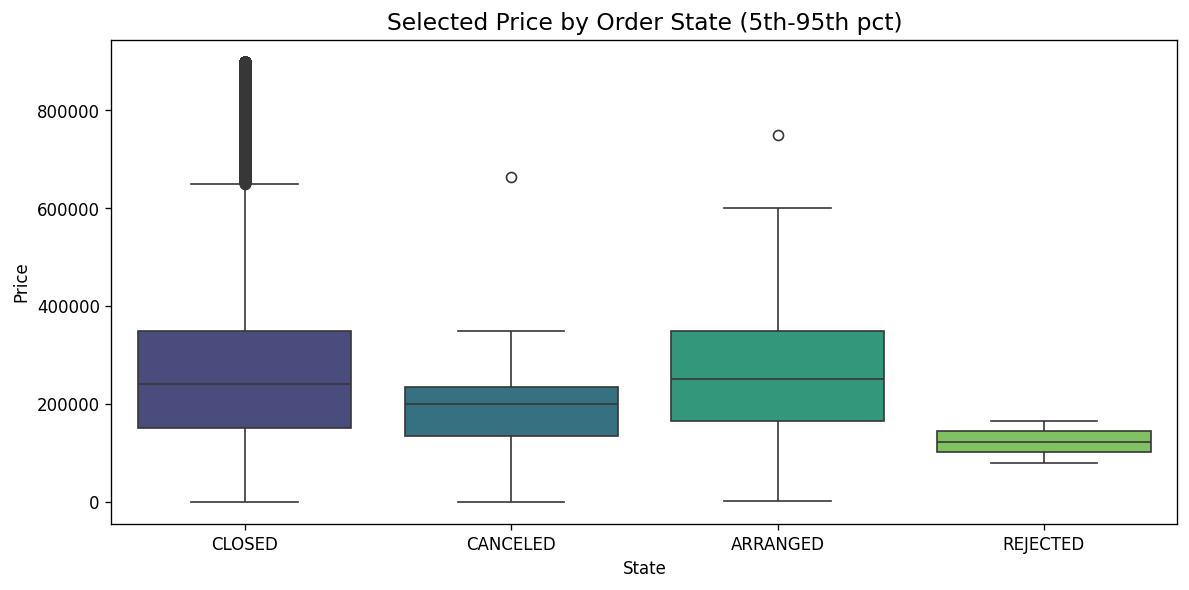

Horizontal bar chart showing columns with missing data and their percentage.
        Key for data cleaning decisions:
        - High missing (>20%): consider dropping or creating a 'missing' indicator
        - Low missing (<5%): impute with median/mode
        - Pattern matters: if missingness correlates with the target, it's informative (MNAR)

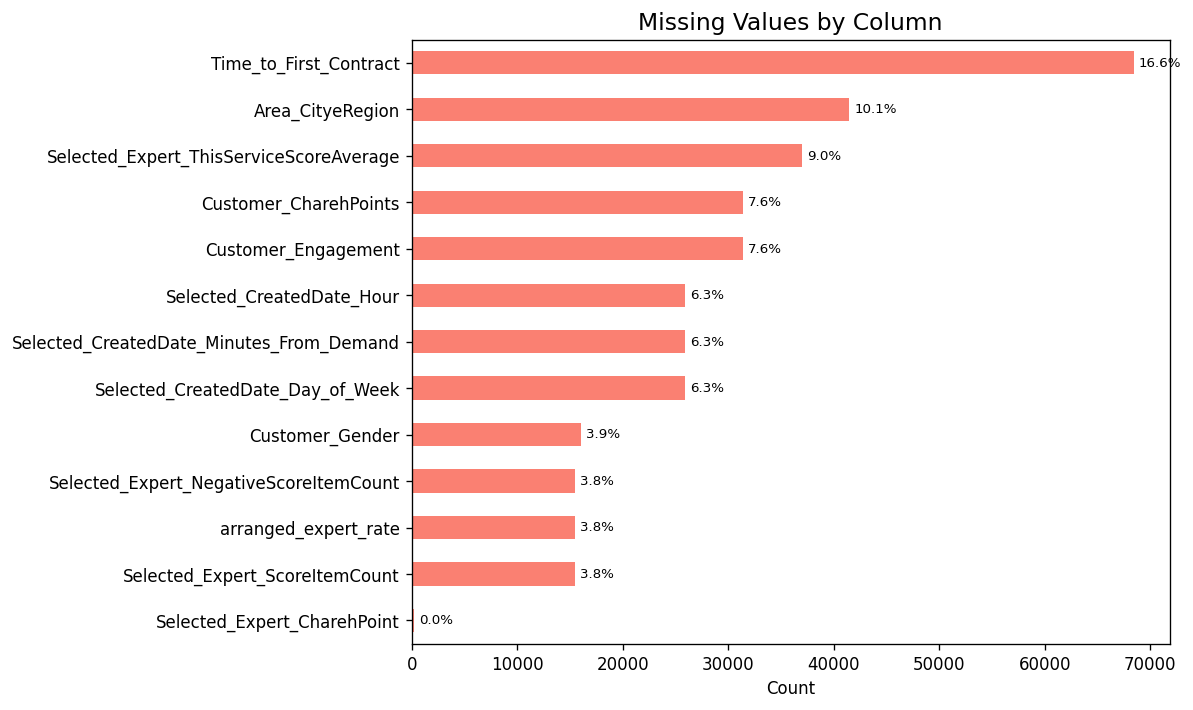

Bar charts showing True/False counts for **Customer_return3Months** and **Customer_return6Months**.
        This is your **class balance check**. If one class dominates (e.g. 80% True),
        you'll likely need techniques like SMOTE, class weights, or stratified splits during modeling.

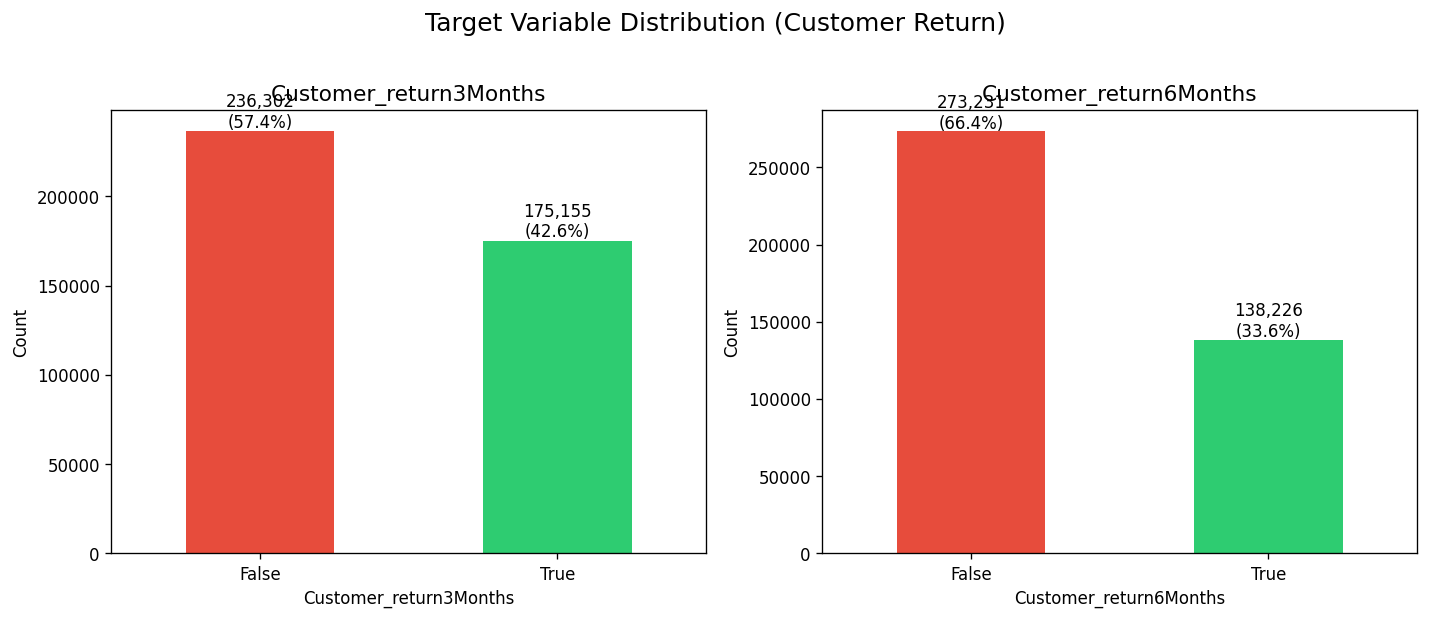

Return rate (proportion returning) grouped by order State (CLOSED, CANCELLED, etc.).
        Shows if order outcome strongly predicts return behavior — e.g. customers with cancelled orders
        may be much less likely to return. **High signal feature.**

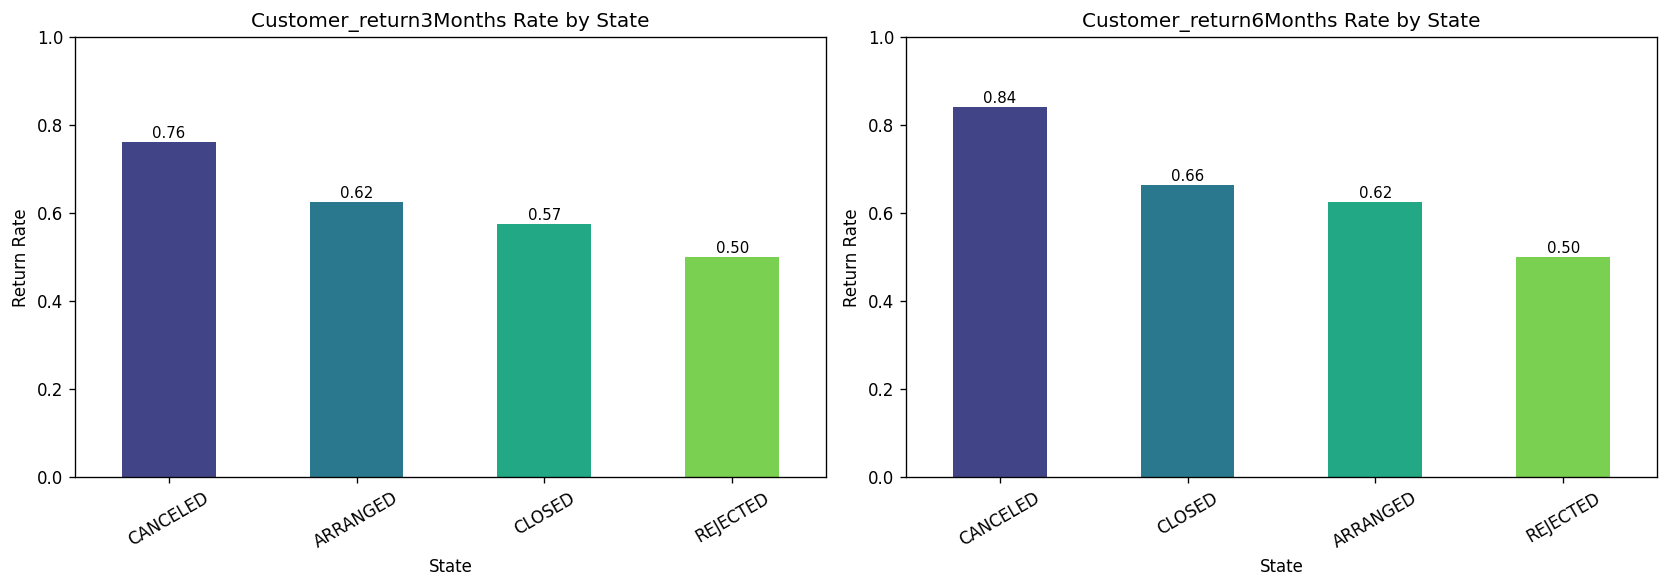

Return rate for the 15 most popular services. Some services naturally have higher
        repeat rates (e.g. cleaning is recurring, locksmith is one-time). This reveals which
        services are sticky and can guide business decisions about customer retention.

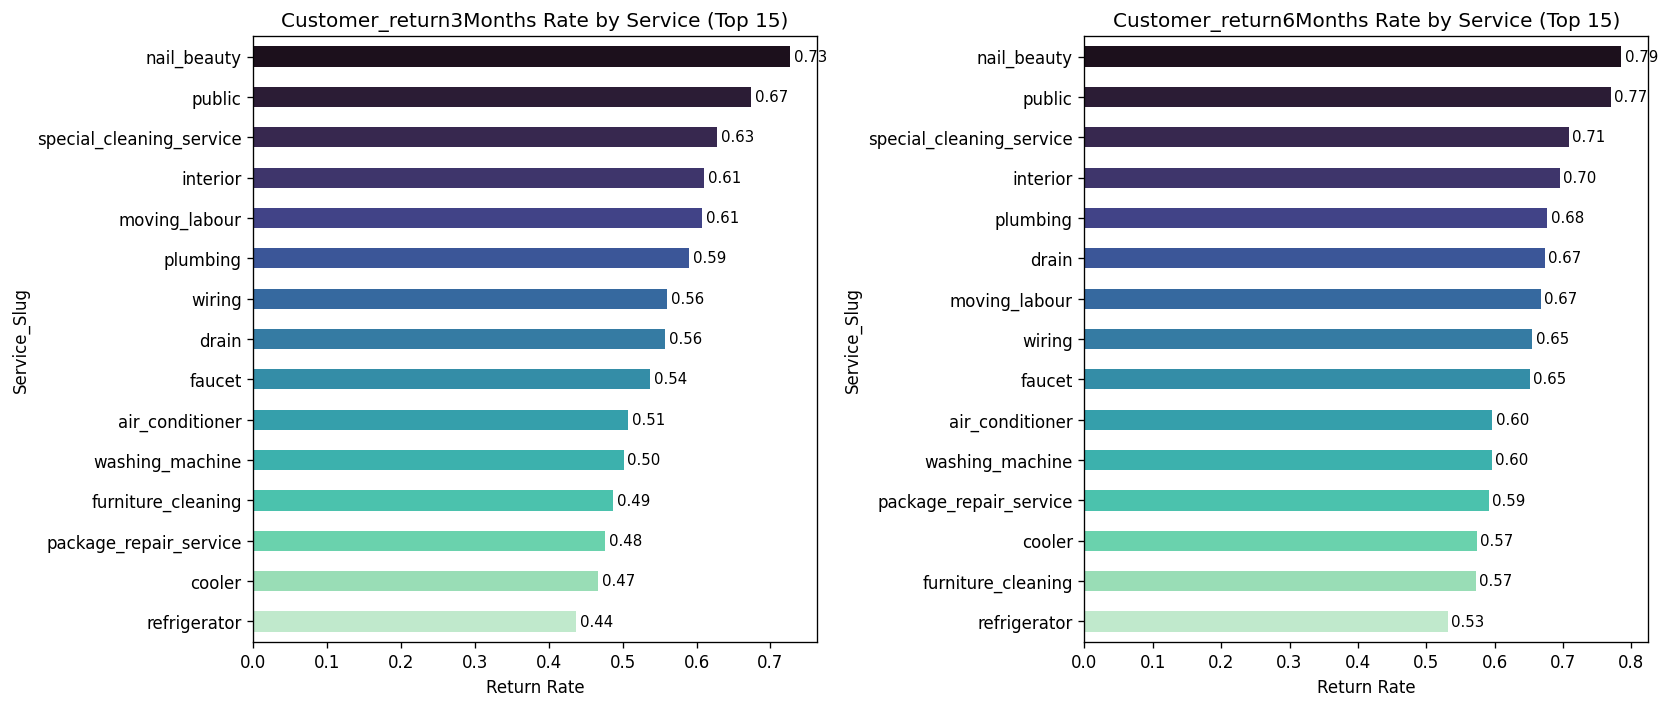

Same idea as service-level but aggregated to category. Categories like 'cleaning'
        likely show higher return rates than 'renovation'. Useful for grouping services in modeling.

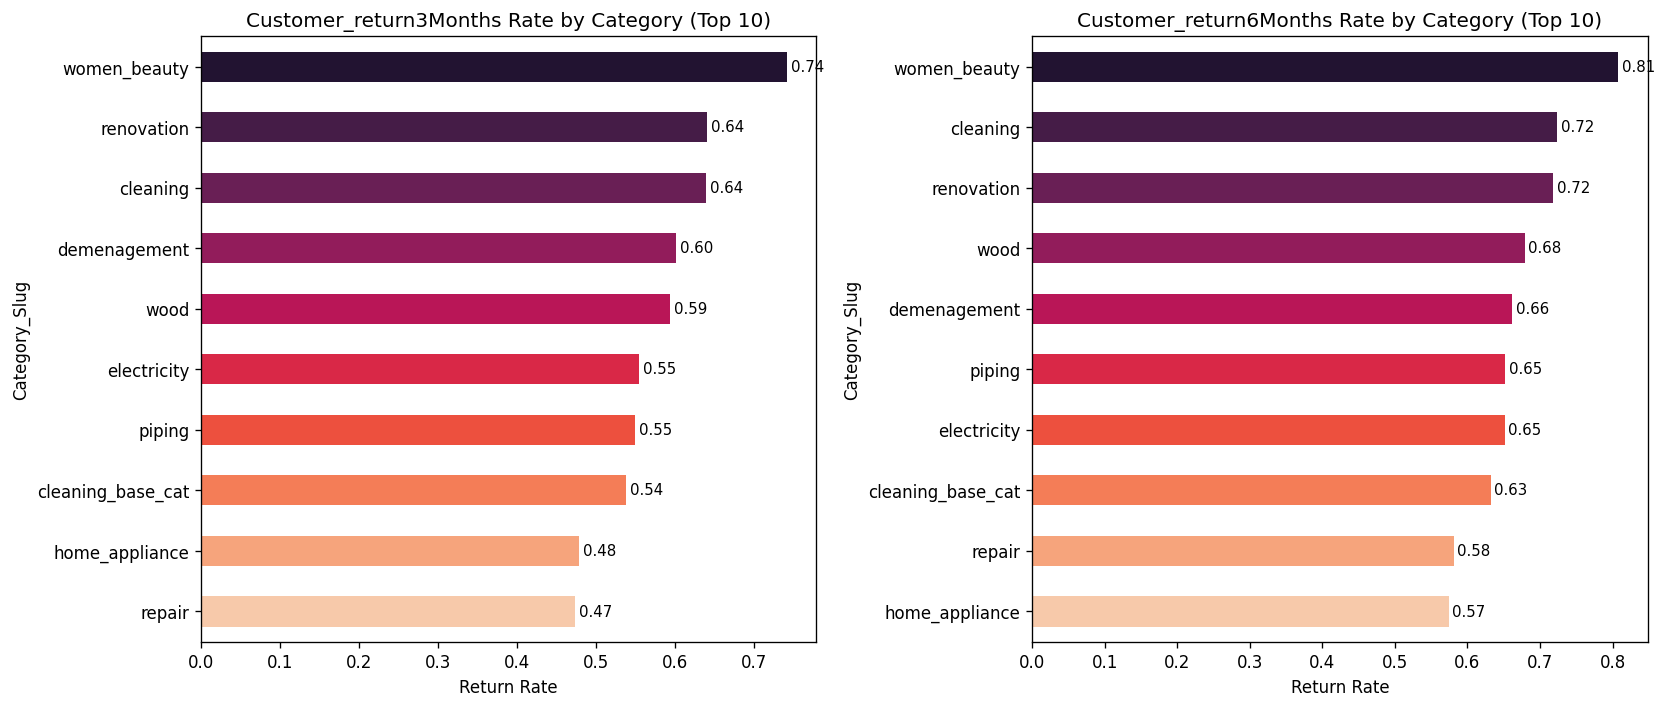

Return rate split by CASH vs other payment methods.
        If online payment users return more, it may indicate higher engagement/trust.
        Small differences here can still be statistically significant with 400K+ rows.

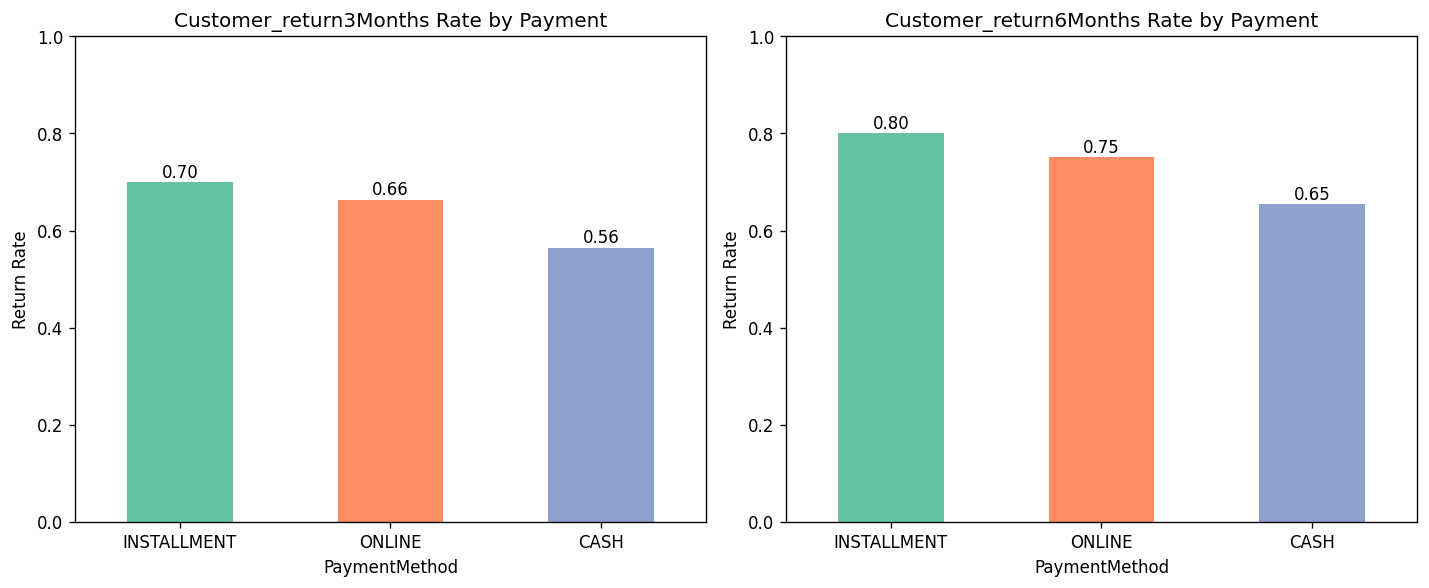

Return rate by MALE / FEMALE. Shows if gender is a useful predictor.
        Even small differences matter at scale. Also consider the ~16K missing gender values.

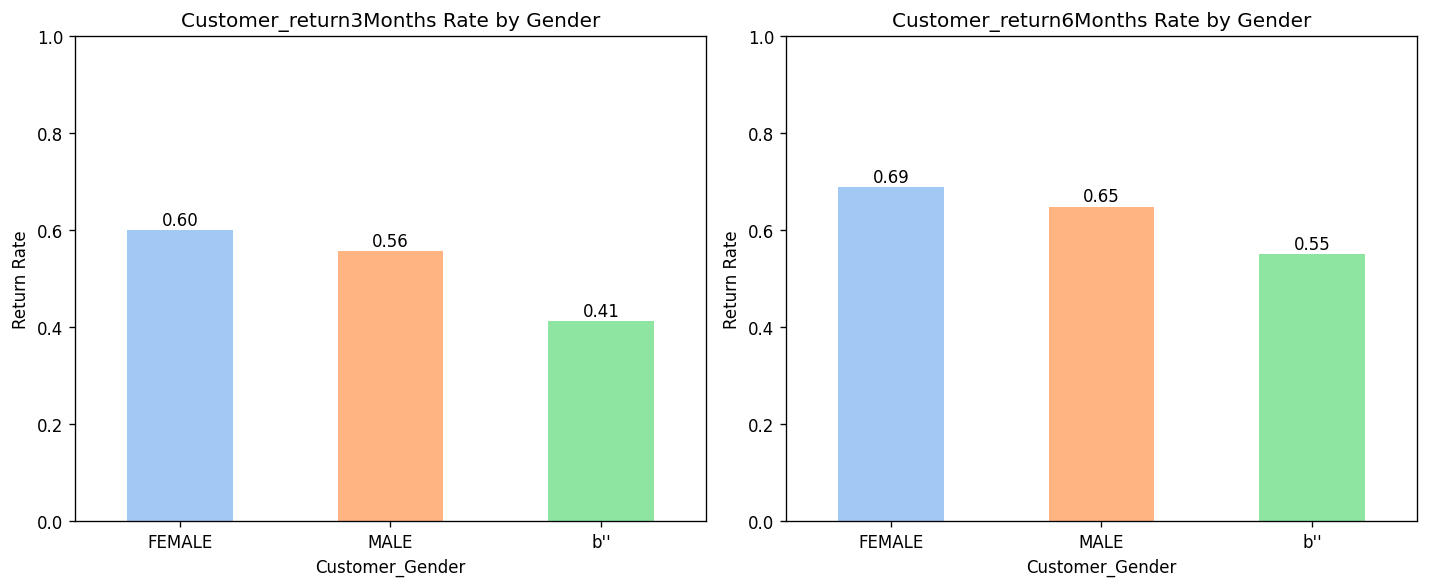

Return rate by device (android, ios, web). Platform differences may reflect
        different user segments — e.g. iOS users might have higher purchasing power and different return behavior.

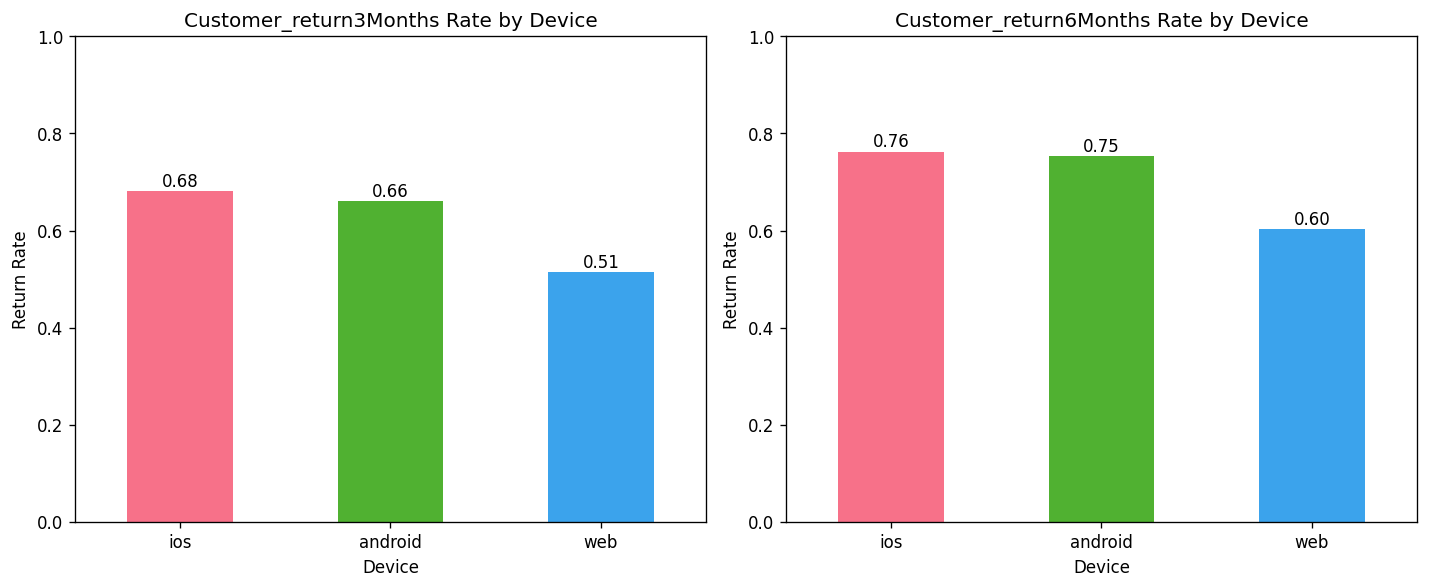

Return rate for AUTOMATIC vs MANUAL expert allocation.
        If manual allocation leads to higher returns, it suggests better expert-customer matching matters.
        Important operational insight for the platform.

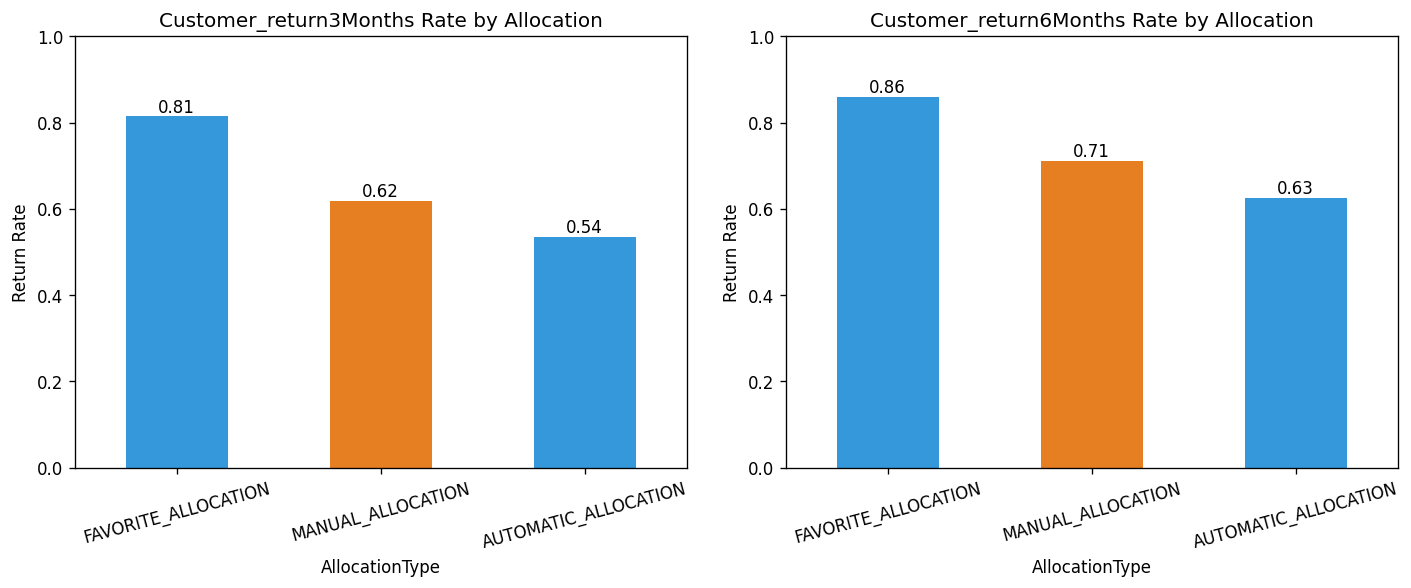

Line chart showing return rate across 24 hours. Reveals if time-of-order
        correlates with return behavior. Late-night or early-morning orders might indicate
        different customer segments with different loyalty patterns.

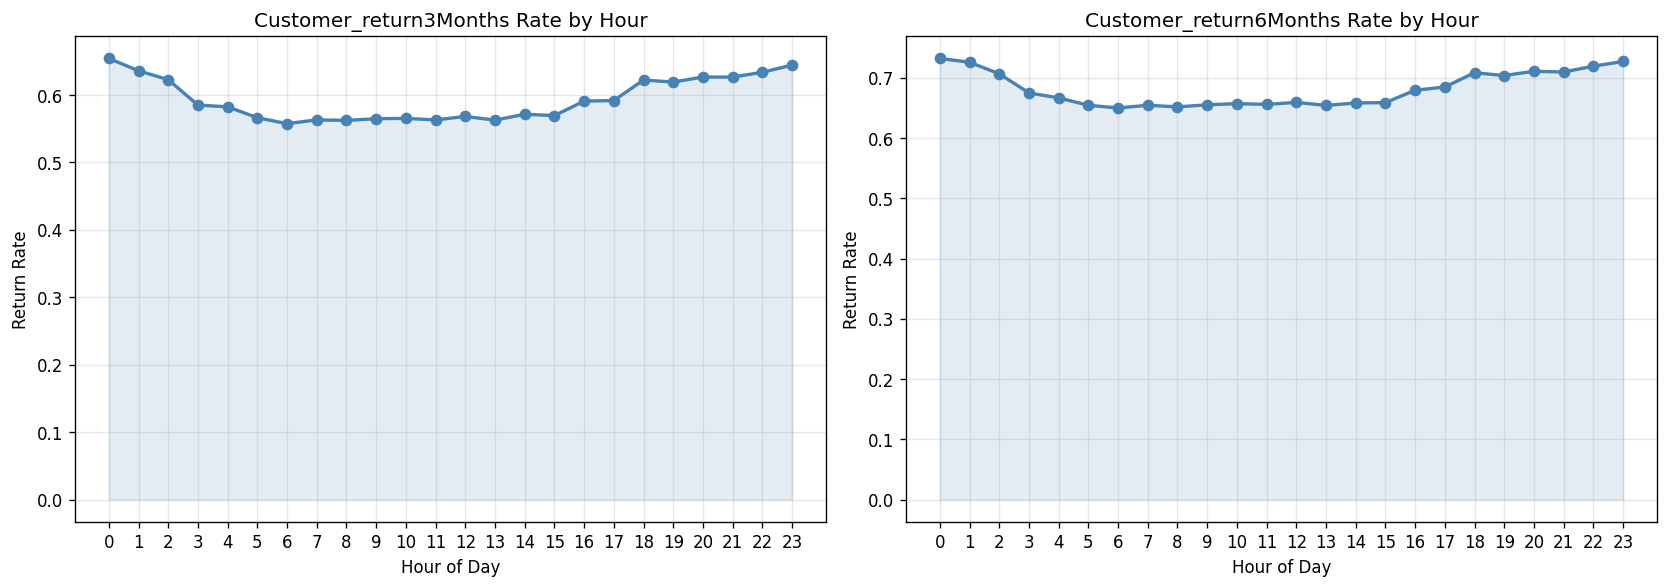

Return rate by weekday (Mon-Sun). In Iran, weekend is Thu-Fri,
        so weekend vs weekday ordering behavior may differ. Look for any day that
        stands out significantly from the rest.

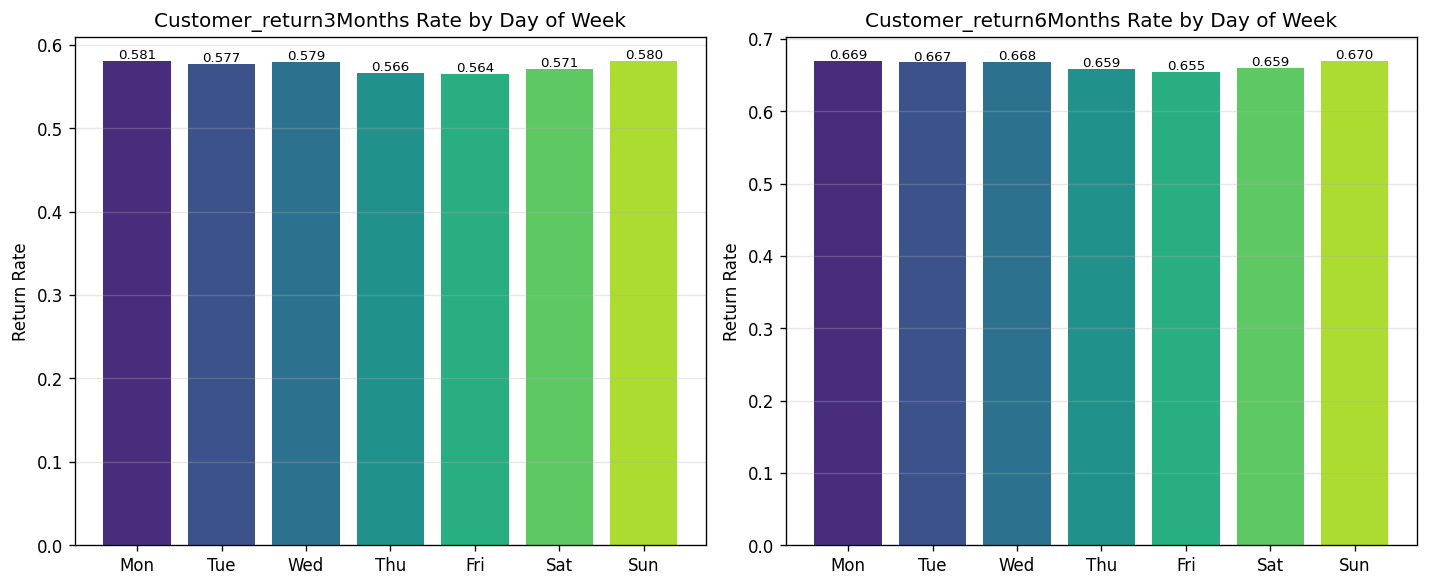

Four plots: return rate by year and season for both 3M and 6M targets.
        - **Year trend**: is return rate improving or declining over time?
        - **Season**: any seasonal pattern in customer loyalty?
        Important for understanding data drift and temporal effects in train/test splits.

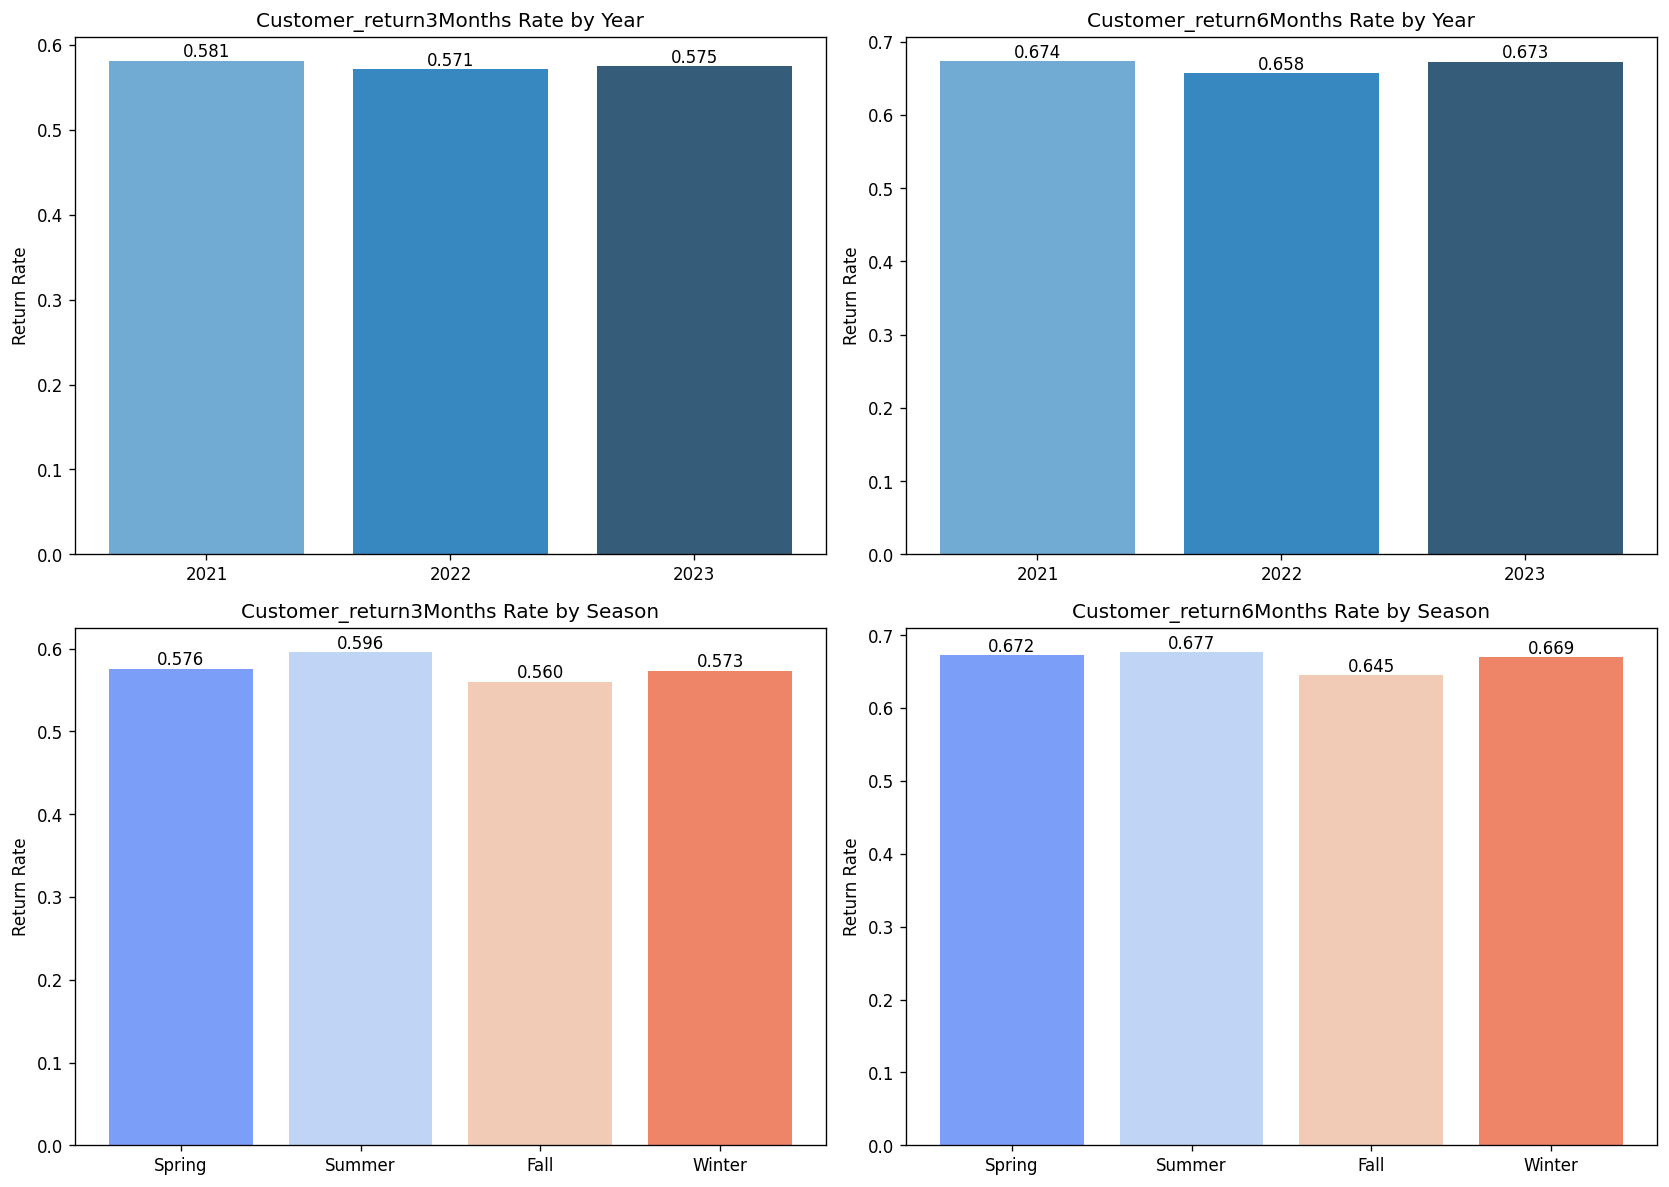

Return rate bucketed by how many previous orders the customer had (0, 1-2, 3-5, ..., 21+).
        Expect a strong positive relationship — customers who ordered more before are more likely to return.
        This is likely one of the **strongest predictors** but beware of data leakage if this is computed at prediction time.

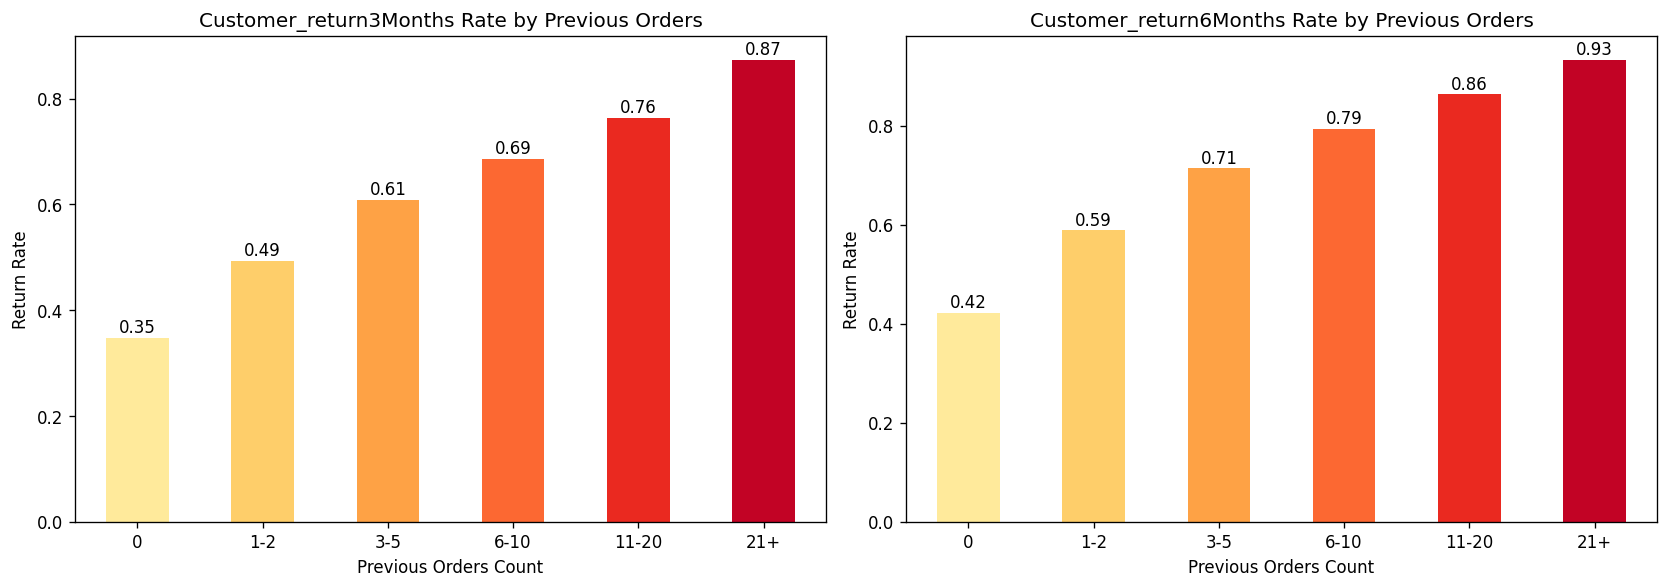

Overlapping normalized histograms for 10 key numeric features, colored by return3M outcome.
        Green = returning customers, Red = non-returning.
        Look for features where the two distributions **separate clearly** — those have the most predictive power.
        Features where distributions overlap completely are less useful.

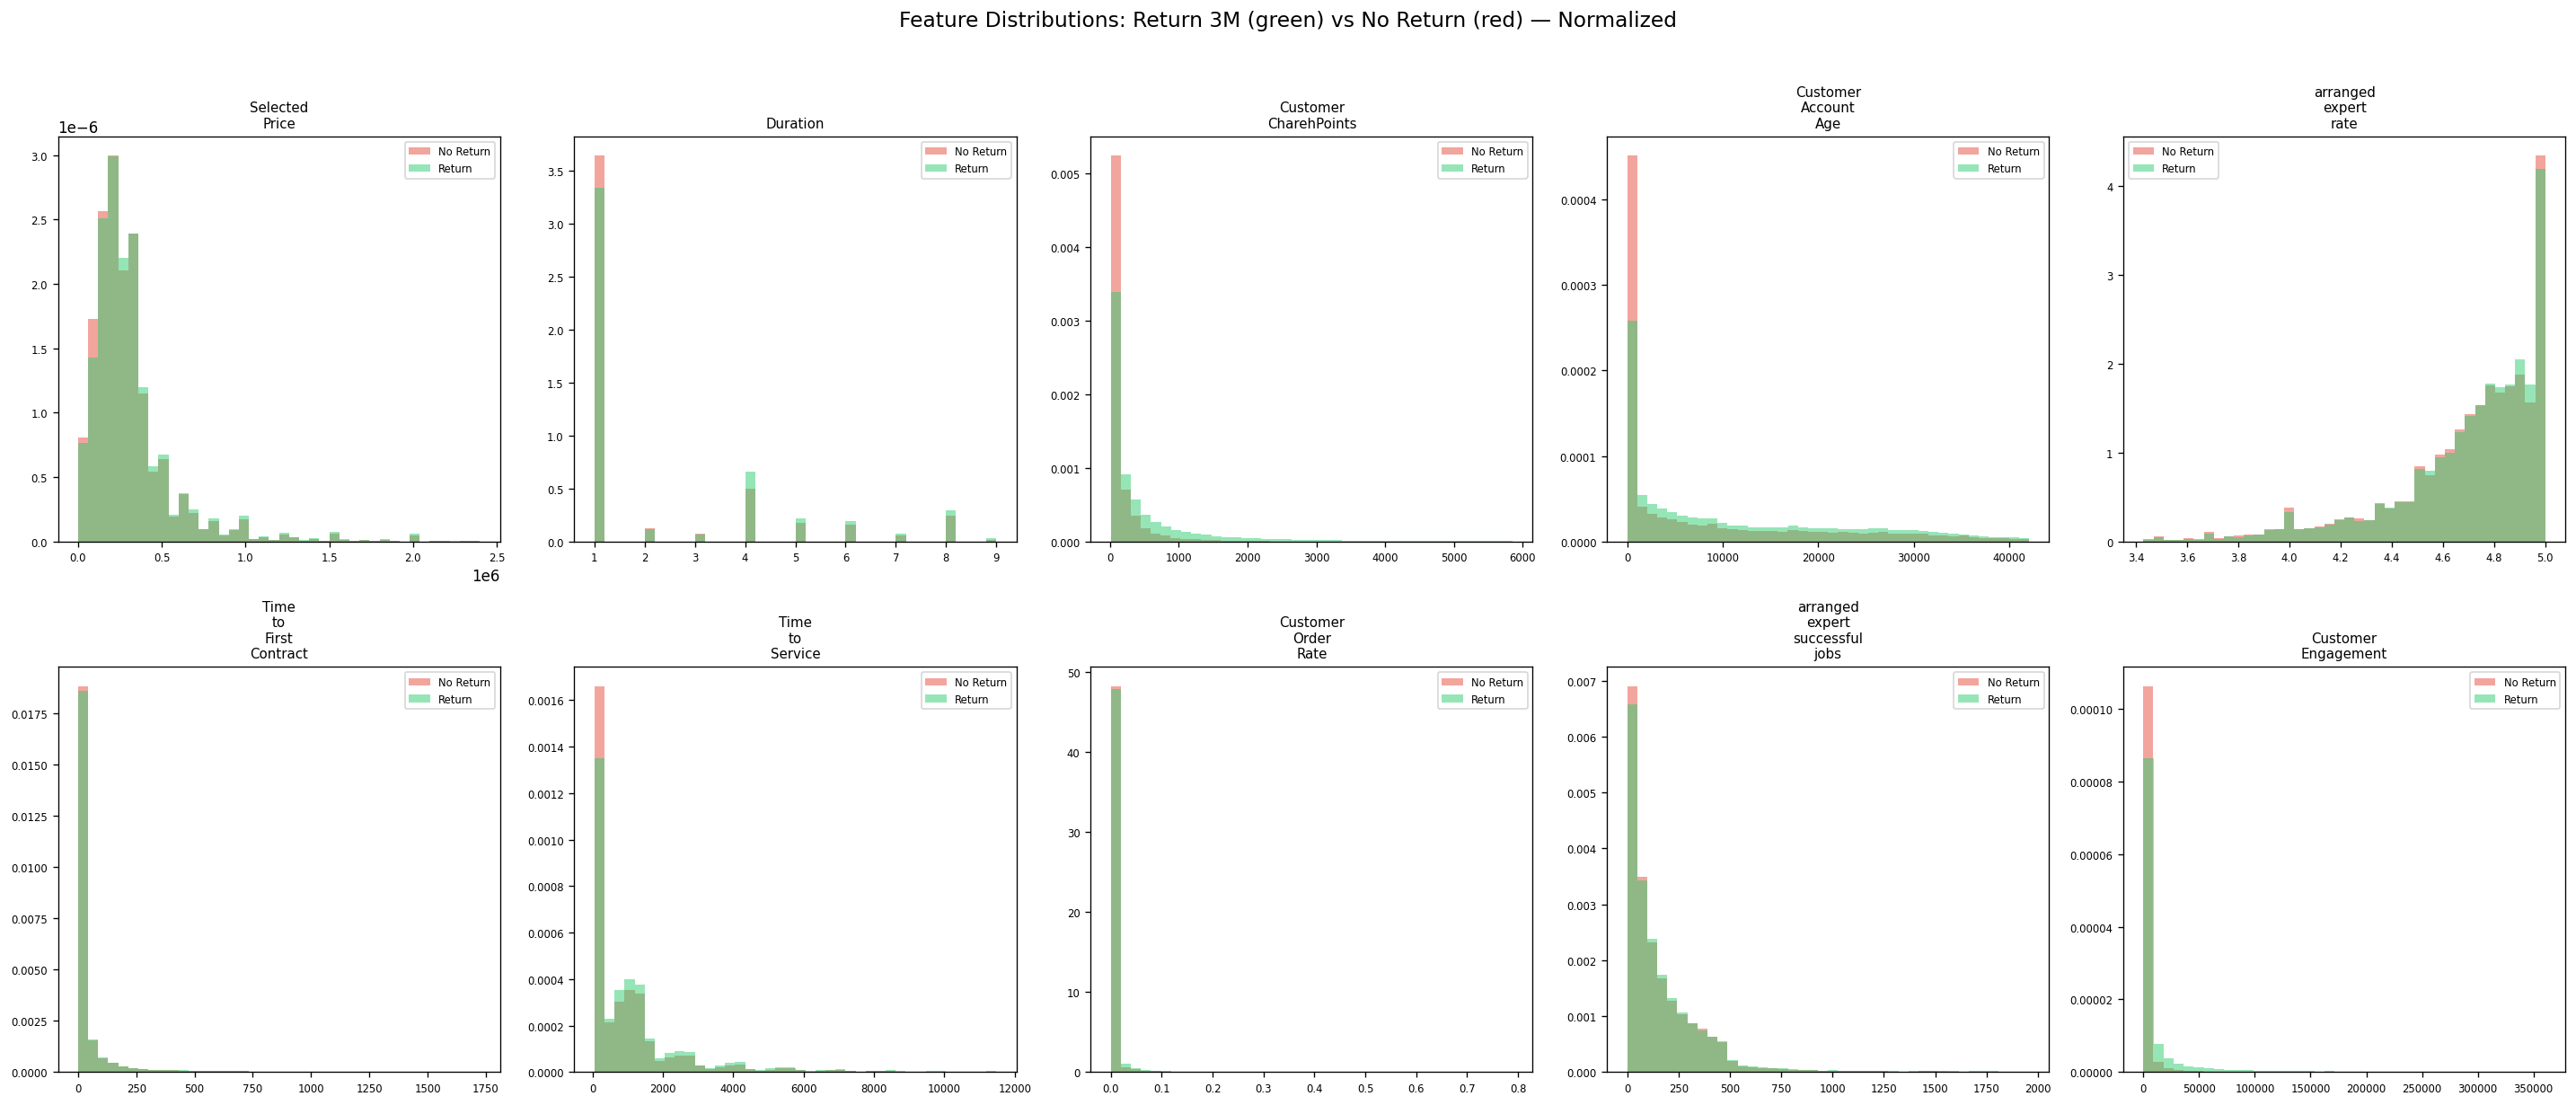

Stacked bar charts showing return proportion split by:
        - **Counselling_Needed**: does pre-service consultation affect return?
        - **Has_Description**: does having an order description correlate with return?
        These boolean features may capture customer engagement level.

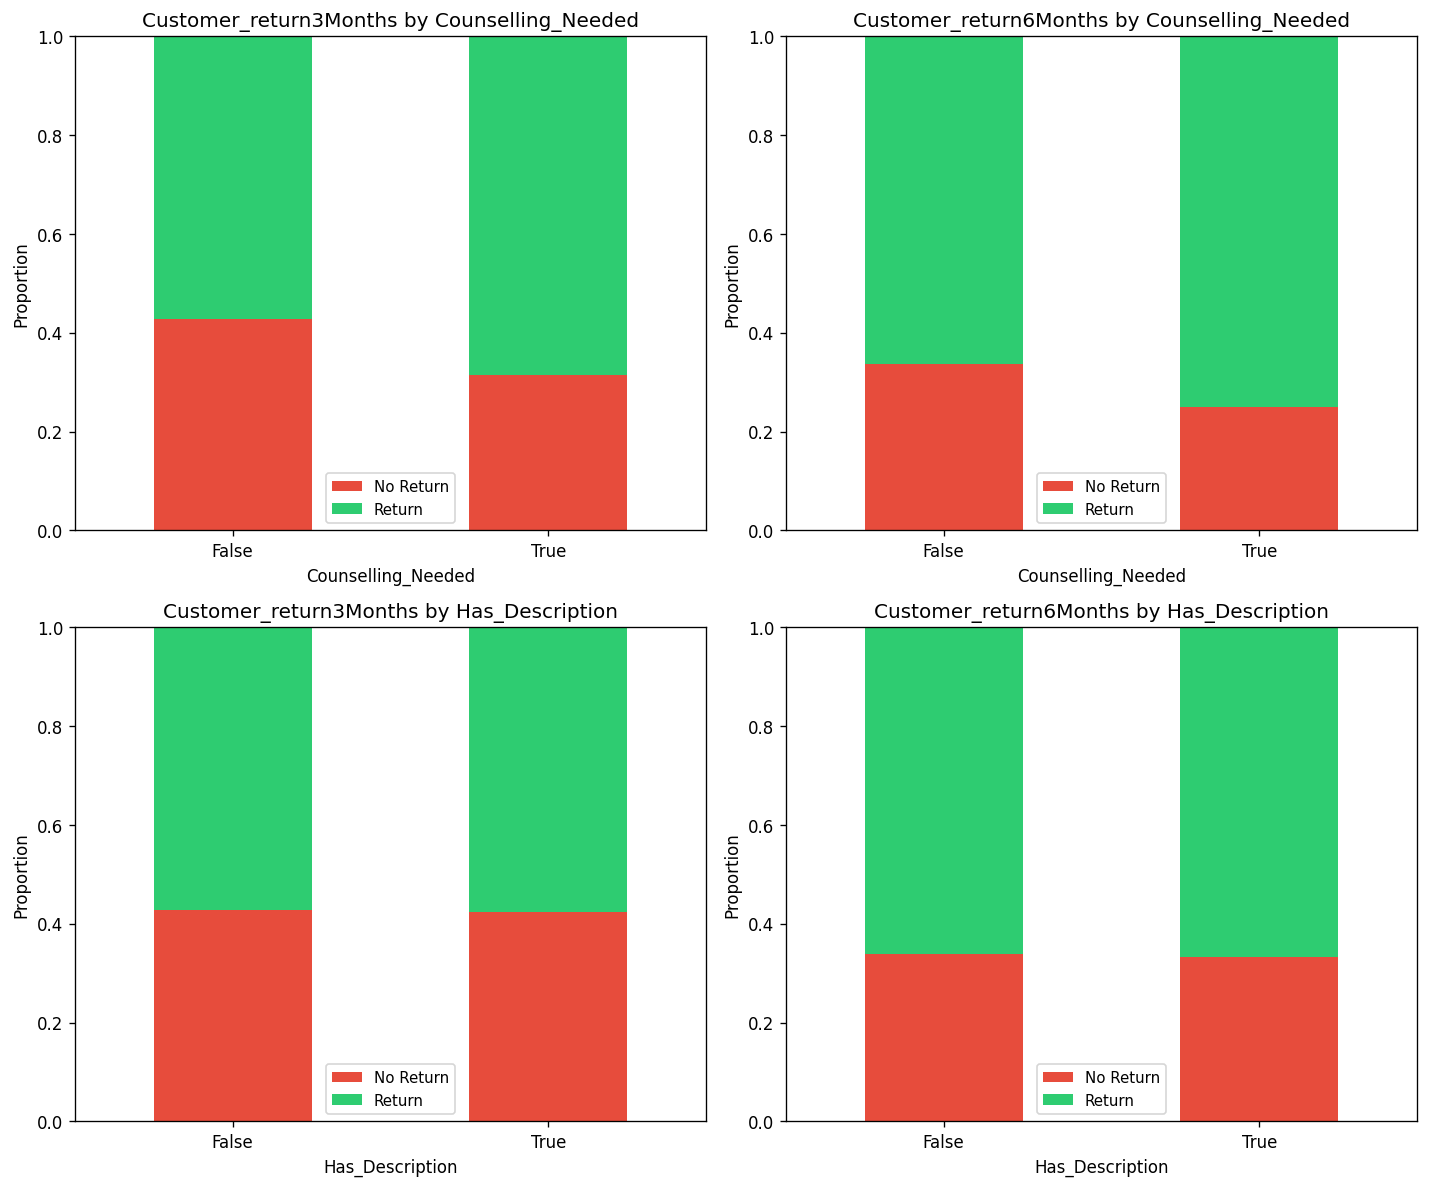

Heatmap showing the overlap between the two targets.
        Key questions: How many customers who return within 3M also return within 6M?
        Are there customers who return in 6M but NOT 3M? This helps you decide
        whether to model them separately or treat 6M as a superset of 3M.

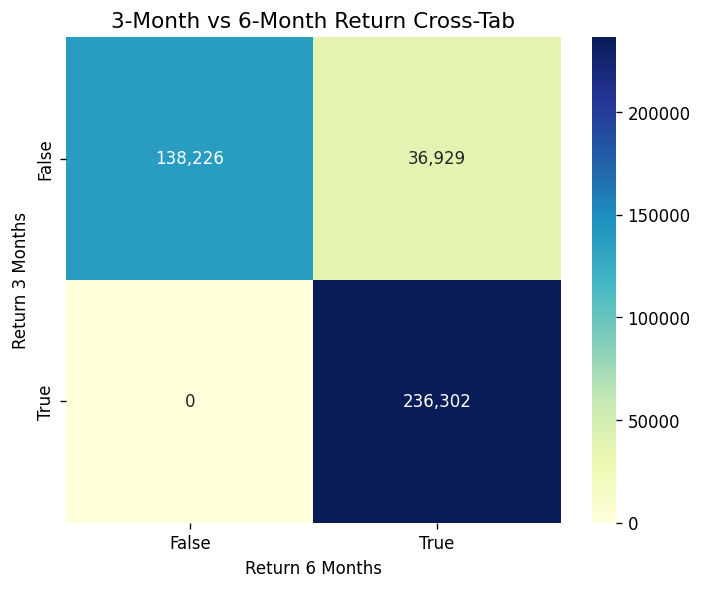

In [3]:
# ============================================================
# Load and render all plots
# ============================================================
plot_files = sorted(glob.glob("plot_*.json"))
print(f"Found {len(plot_files)} plot files\n")

for fpath in plot_files:
    with open(fpath, 'r') as f:
        data = json.load(f)

    key = list(data.keys())[0]
    b64 = data[key]

    info = descriptions.get(key, {"title": key, "desc": "No description available."})

    display(HTML(f"<hr><h2>📊 {info['title']}</h2>"))
    display(Markdown(info['desc']))
    display(Image(data=base64.b64decode(b64)))
    print()

display(HTML("<hr><h2>✅ All plots rendered!</h2>"))